https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 50 e top 100)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Oversample
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * KNN
    * Métricas de desempenho
        * F1-score positivo (iteração por iteração)
        * F1-score negativo (iteração por iteração)
        * curva ROC
        * curva Precision-Recall
        * matriz de confusão
        * avaliação de thresholds
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

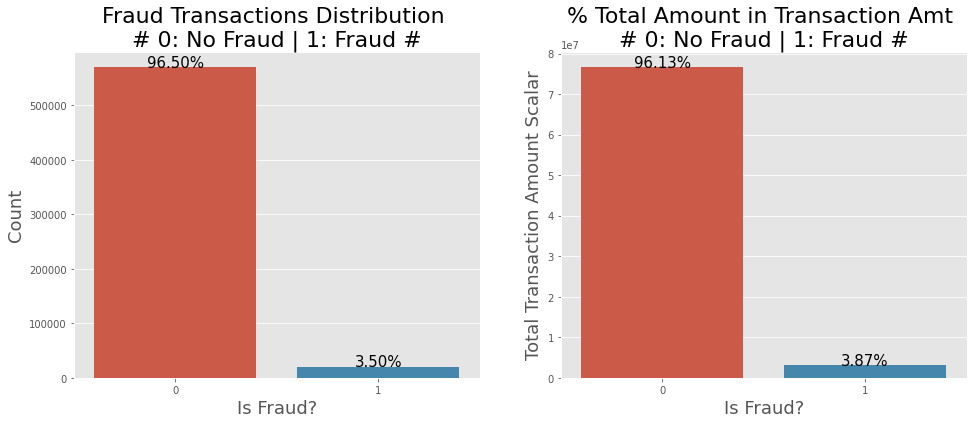

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_28: 76.12727334304196%
id_29: 76.12727334304196%
id_30: 86.86541131845429%
id_31: 76.24513157449114%
id_32: 86.86185525112609%
id_33: 87.58949436109323%
id_34: 86.82477054898906%
id_35: 76.12608798726589%
id_36: 76.12608798726589%
id_37: 76.12608798726589%
id_38: 76.12608798726589%
DeviceType: 76.15572188166763%
DeviceInfo: 79.90551021099333%
Date: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

### Oversampling com SMOTE

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE(random_state=42)

In [61]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 7.01 s, sys: 962 ms, total: 7.97 s
Wall time: 2.8 s


In [62]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [63]:
from imblearn.over_sampling import BorderlineSMOTE

In [64]:
smote = BorderlineSMOTE(random_state=42)

In [65]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min 29s, sys: 495 ms, total: 2min 30s
Wall time: 16.8 s


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [67]:
from imblearn.over_sampling import ADASYN

In [68]:
adasyn = ADASYN(random_state=42)

In [69]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 5s, sys: 452 ms, total: 2min 6s
Wall time: 14.4 s


In [70]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [71]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.1e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [72]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Oversampling com SMOTE

In [73]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [74]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [75]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [76]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V29', 'V30',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V69',
       'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310', 'ProductCD_C',
       'M4_M2'],
      dtype='object')

In [77]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       '

### Oversampling com Borderline-SMOTE

In [78]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [79]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [80]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [81]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [82]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
    

### Oversampling com AdaSyn

In [83]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [84]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [85]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [86]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V50', 'V51',
       'V52', 'V80', 'V81', 'V84', 'V85', 'V91', 'V92', 'V93', 'V96', 'V99',
       'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [87]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
  

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [89]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [90]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [91]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

F1-Score Positivo (Teste): 0.597547974413646
F1-Score Negativo (Teste): 0.9867956206932735
F1-Score Positivo Médio (Validação Cruzada): 0.5021700887870186
F1-Score Positivo Fold 1: 0.5228758169934641
F1-Score Positivo Fold 2: 0.4891846921797005
F1-Score Positivo Fold 3: 0.5129870129870129
F1-Score Positivo Fold 4: 0.5071315372424723
F1-Score Positivo Fold 5: 0.5472312703583062
F1-Score Positivo Fold 6: 0.504950495049505
F1-Score Positivo Fold 7: 0.47000000000000003
F1-Score Positivo Fold 8: 0.4771573604060914
F1-Score Positivo Fold 9: 0.4909983633387889
F1-Score Positivo Fold 10: 0.49918433931484507
F1-Score Negativo Médio (Validação Cruzada): 0.9868200152830191
F1-Score Negativo Fold 1: 0.987309865275967
F1-Score Negativo Fold 2: 0.9866643499413579
F1-Score Negativo Fold 3: 0.9869599234982178
F1-Score Negativo Fold 4: 0.9864729676830064
F1-Score Negativo Fold 5: 0.9879172461752433
F1-Score Negativo Fold 6: 0.9869655891553704
F1-Score Negativo Fold 7: 0.9861871253583527
F1-Score Negati

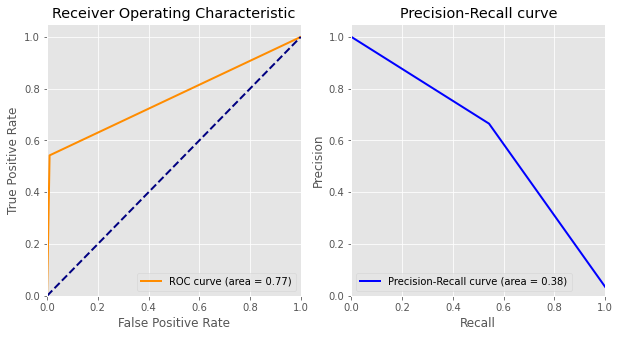

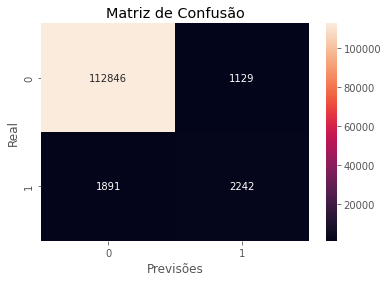

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.67      0.54      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.77      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 6min 12s, sys: 437 ms, total: 6min 12s
Wall time: 6min 12s


In [92]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [93]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 59.8 s, sys: 126 µs, total: 59.8 s
Wall time: 59.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.597547974413646  0.986795620693274
Threshold: 0.05    0.2152190622598   0.87468763961098
Threshold: 0.1   0.311483907450167  0.932040280006512
Threshold: 0.15  0.404337722695585  0.958192131349559
Threshold: 0.2   0.476281439032155  0.970579292829932
Threshold: 0.25  0.518599363346976   0.97649863911447
Threshold: 0.3    0.54156722354813  0.979616200919703
Threshold: 0.35  0.577038269550749  0.983217503444087
Threshold: 0.4   0.590968353680218  0.984849349588856
Threshold: 0.45  0.594251586412841  0.985708588432766
Threshold: 0.5   0.596141225882662  0.986539630878795
Threshold: 0.55  0.596680497925311  0.987265597023399
Threshold: 0.6   0.589573732718894  0.987569349942427
Threshold: 0.65  0.575293592983499  0.987550601553887
Threshold: 0.7   0.561787365177196  0.987620034301733
Threshold: 0.75  0.536248191609066  0.987456249048892

F1-Score Positivo (Teste): 0.4734174485064164
F1-Score Negativo (Teste): 0.9784835839836434
F1-Score Positivo Médio (Validação Cruzada): 0.42804033709555506
F1-Score Positivo Fold 1: 0.47664670658682634
F1-Score Positivo Fold 2: 0.4265402843601896
F1-Score Positivo Fold 3: 0.41232227488151657
F1-Score Positivo Fold 4: 0.43146603098927294
F1-Score Positivo Fold 5: 0.4463414634146341
F1-Score Positivo Fold 6: 0.44311377245508987
F1-Score Positivo Fold 7: 0.4183796856106409
F1-Score Positivo Fold 8: 0.40199750312109866
F1-Score Positivo Fold 9: 0.4221954161640531
F1-Score Positivo Fold 10: 0.40140023337222874
F1-Score Negativo Médio (Validação Cruzada): 0.9790900659852163
F1-Score Negativo Fold 1: 0.9808223987361214
F1-Score Negativo Fold 2: 0.9787514268153481
F1-Score Negativo Fold 3: 0.9782246026868031
F1-Score Negativo Fold 4: 0.9790633366984155
F1-Score Negativo Fold 5: 0.9800894658363302
F1-Score Negativo Fold 6: 0.9795936279457585
F1-Score Negativo Fold 7: 0.9788988813336258
F1-Scor

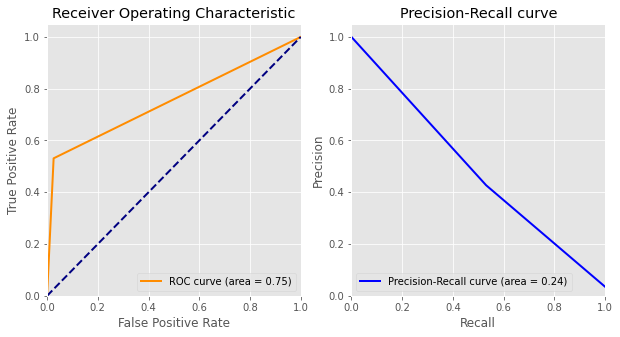

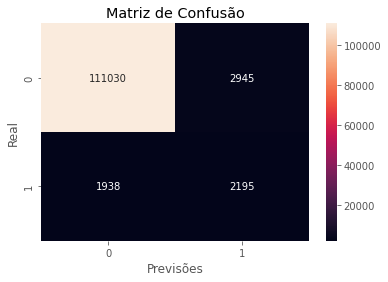

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.53      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 54.4 s, sys: 300 ms, total: 54.7 s
Wall time: 54.3 s


In [94]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [95]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.14 s, sys: 7.79 ms, total: 1.14 s
Wall time: 1.14 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.473417448506416  0.978483583983643
Threshold: 0.05  0.333239038189533  0.957546065310975
Threshold: 0.1   0.354468828308907  0.961886956560725
Threshold: 0.15  0.400417645523362  0.969335582027652
Threshold: 0.2   0.420577949567458  0.972061238074107
Threshold: 0.25  0.432912844036697  0.973714518586768
Threshold: 0.3   0.438297457874744  0.974476541166369
Threshold: 0.35  0.456768648316791  0.976554806286792
Threshold: 0.4   0.463635417750494  0.977251163919596
Threshold: 0.45  0.465495608531995  0.977445599421139
Threshold: 0.5   0.471264367816092  0.978097169561767
Threshold: 0.55  0.477970919427135  0.978971149738626
Threshold: 0.6   0.480635551142006  0.979278283799906
Threshold: 0.65  0.481727574750831  0.979400139093078
Threshold: 0.7   0.484577559231113   0.97970677790098
Threshold: 0.75  0.485669149176258  0.979951969175823

0:	learn: 0.6041906	total: 117ms	remaining: 466ms
1:	learn: 0.5498908	total: 184ms	remaining: 277ms
2:	learn: 0.5099933	total: 248ms	remaining: 165ms
3:	learn: 0.4684057	total: 320ms	remaining: 79.9ms
4:	learn: 0.4409434	total: 384ms	remaining: 0us
0:	learn: 0.5418533	total: 7.2ms	remaining: 28.8ms
1:	learn: 0.4234363	total: 14.3ms	remaining: 21.4ms
2:	learn: 0.3472970	total: 21ms	remaining: 14ms
3:	learn: 0.2931230	total: 27.3ms	remaining: 6.83ms
4:	learn: 0.2432306	total: 34.9ms	remaining: 0us
0:	learn: 0.5412085	total: 7.17ms	remaining: 28.7ms
1:	learn: 0.4225214	total: 14.5ms	remaining: 21.8ms
2:	learn: 0.3462526	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.2922745	total: 28.2ms	remaining: 7.04ms
4:	learn: 0.2425982	total: 35.7ms	remaining: 0us
0:	learn: 0.5415613	total: 6.84ms	remaining: 27.4ms
1:	learn: 0.4227770	total: 14.9ms	remaining: 22.4ms
2:	learn: 0.3465860	total: 21.8ms	remaining: 14.6ms
3:	learn: 0.2924947	total: 28.3ms	remaining: 7.08ms
4:	learn: 0.2431587	total: 36ms	re

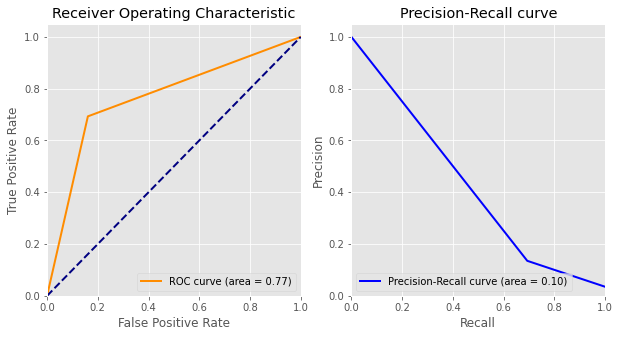

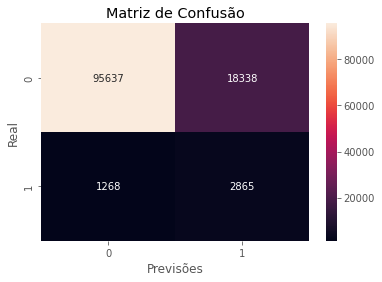

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.14      0.69      0.23      4133

    accuracy                           0.83    118108
   macro avg       0.56      0.77      0.57    118108
weighted avg       0.96      0.83      0.88    118108

CPU times: user 20.9 s, sys: 679 ms, total: 21.5 s
Wall time: 9.4 s


In [96]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [97]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.15 s, sys: 18.7 ms, total: 2.17 s
Wall time: 1.75 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.226160404167982  0.907027693474962
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.078739232576351  0.297935191263353
Threshold: 0.3   0.095112998858349  0.523679364156247
Threshold: 0.35  0.131665520510009  0.743883385504323
Threshold: 0.4    0.16152388357063  0.823078263900994
Threshold: 0.45  0.177323720179272  0.852451159051989
Threshold: 0.5   0.226160404167982  0.907027693474962
Threshold: 0.55  0.287692112282484  0.949126865333152
Threshold: 0.6   0.345887937261377  0.972016333737998
Threshold: 0.65  0.356671411932186  0.978244029253049
Threshold: 0.7   0.349152542372881  0.983327254728286
Threshold: 0.75  0.205980066445183  0.983474503025065

F1-Score Positivo (Teste): 0.319568345323741
F1-Score Negativo (Teste): 0.9574569531657641
F1-Score Positivo Médio (Validação Cruzada): 0.3102739171305597
F1-Score Positivo Fold 1: 0.4290909090909091
F1-Score Positivo Fold 2: 0.36567164179104483
F1-Score Positivo Fold 3: 0.38202247191011235
F1-Score Positivo Fold 4: 0.36158192090395486
F1-Score Positivo Fold 5: 0.39015151515151514
F1-Score Positivo Fold 6: 0.35793357933579334
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.29239766081871343
F1-Score Positivo Fold 9: 0.32046332046332043
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9845205511949106
F1-Score Negativo Fold 1: 0.9863904299583912
F1-Score Negativo Fold 2: 0.9852724594992636
F1-Score Negativo Fold 3: 0.9857068607068608
F1-Score Negativo Fold 4: 0.9853189554371833
F1-Score Negativo Fold 5: 0.9860569844981381
F1-Score Negativo Fold 6: 0.9849220103986135
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Sco

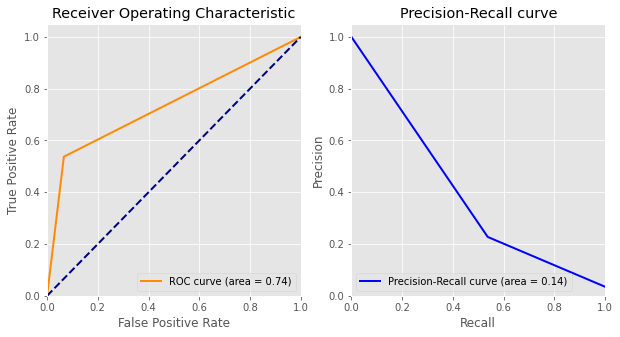

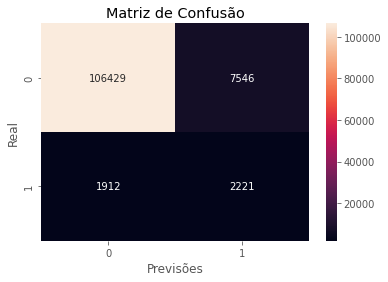

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.23      0.54      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.74      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 5min 19s, sys: 354 ms, total: 5min 20s
Wall time: 5min 19s


In [98]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [99]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.58 s, sys: 0 ns, total: 2.58 s
Wall time: 2.58 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.319568345323741  0.957456953165764
Threshold: 0.05  0.087441593301594    0.4329418547983
Threshold: 0.1   0.105331617865373  0.617619510898137
Threshold: 0.15  0.137029061382539  0.764648516425196
Threshold: 0.2   0.166051753131039  0.830796494426423
Threshold: 0.25  0.185437896913307  0.863723741234724
Threshold: 0.3   0.211391451028245  0.894539555465964
Threshold: 0.35  0.242658836091831  0.920361186488257
Threshold: 0.4   0.275004128364617  0.939596145820435
Threshold: 0.45  0.297912593807151   0.94947789743101
Threshold: 0.5   0.319568345323741  0.957456953165764
Threshold: 0.55  0.335682892445476  0.964261655892968
Threshold: 0.6   0.359219586840092  0.970322466335932
Threshold: 0.65  0.373500605260262   0.97493494886166
Threshold: 0.7   0.374825529755107  0.978422055313465
Threshold: 0.75   0.37573836622965  0.981101297568422

F1-Score Positivo (Teste): 0.3053953172718018
F1-Score Negativo (Teste): 0.9537883610783768
F1-Score Positivo Médio (Validação Cruzada): 0.32589567618197385
F1-Score Positivo Fold 1: 0.36742424242424243
F1-Score Positivo Fold 2: 0.3320463320463321
F1-Score Positivo Fold 3: 0.35249042145593873
F1-Score Positivo Fold 4: 0.3157894736842105
F1-Score Positivo Fold 5: 0.35316698656429946
F1-Score Positivo Fold 6: 0.3395522388059702
F1-Score Positivo Fold 7: 0.306483300589391
F1-Score Positivo Fold 8: 0.2982791586998088
F1-Score Positivo Fold 9: 0.29469548133595286
F1-Score Positivo Fold 10: 0.2990291262135923
F1-Score Negativo Médio (Validação Cruzada): 0.984849962729748
F1-Score Negativo Fold 1: 0.9855373690135967
F1-Score Negativo Fold 2: 0.9850242382271469
F1-Score Negativo Fold 3: 0.9853679653679653
F1-Score Negativo Fold 4: 0.9848111125535506
F1-Score Negativo Fold 5: 0.9854118869313018
F1-Score Negativo Fold 6: 0.984666031360998
F1-Score Negativo Fold 7: 0.9847272097953532
F1-Score Neg

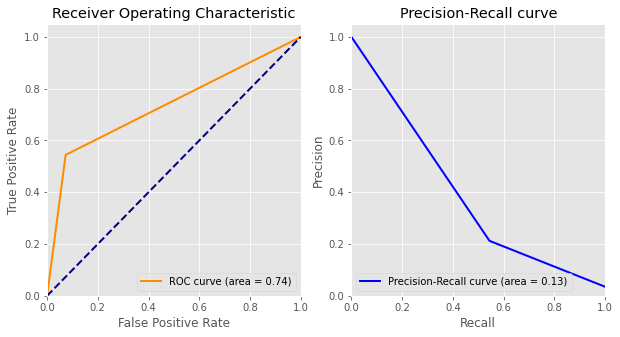

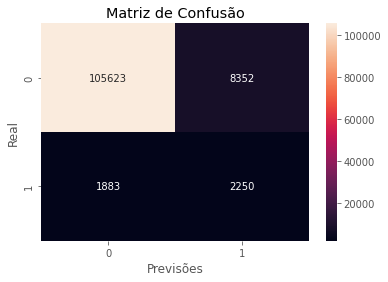

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.54      0.31      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.74      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 6min 24s, sys: 2.84 s, total: 6min 27s
Wall time: 6min 26s


In [100]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [101]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 18.1 s, sys: 4.02 ms, total: 18.1 s
Wall time: 18.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.305395317271802  0.953788361078377
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.305395317271802  0.953788361078377
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.3345185606599345
F1-Score Negativo (Teste): 0.9578760679528616
F1-Score Positivo Médio (Validação Cruzada): 0.2660582785028741
F1-Score Positivo Fold 1: 0.28169014084507044
F1-Score Positivo Fold 2: 0.23859649122807017
F1-Score Positivo Fold 3: 0.25828970331588136
F1-Score Positivo Fold 4: 0.23571428571428574
F1-Score Positivo Fold 5: 0.3005181347150259
F1-Score Positivo Fold 6: 0.27739726027397266
F1-Score Positivo Fold 7: 0.27835051546391754
F1-Score Positivo Fold 8: 0.24338624338624337
F1-Score Positivo Fold 9: 0.2652329749103943
F1-Score Positivo Fold 10: 0.28140703517587945
F1-Score Negativo Médio (Validação Cruzada): 0.9817335828496354
F1-Score Negativo Fold 1: 0.9823024204042683
F1-Score Negativo Fold 2: 0.9811730001735207
F1-Score Negativo Fold 3: 0.9815610221701593
F1-Score Negativo Fold 4: 0.9814413320613997
F1-Score Negativo Fold 5: 0.982424163520375
F1-Score Negativo Fold 6: 0.9816824377116069
F1-Score Negativo Fold 7: 0.9817708333333334
F1-Scor

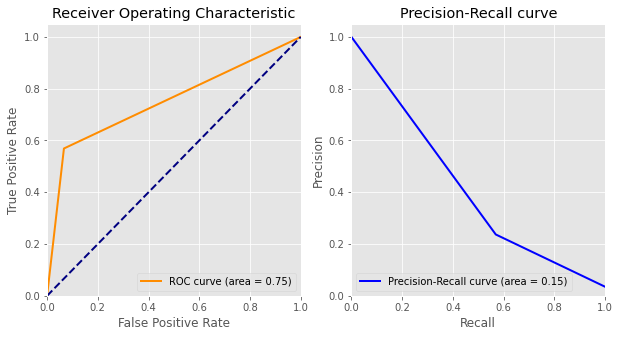

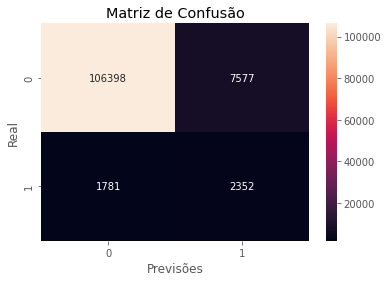

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.24      0.57      0.33      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.75      0.65    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 28min 25s, sys: 713 ms, total: 28min 26s
Wall time: 2min 45s


In [102]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [103]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 42min 15s, sys: 1.9 s, total: 3h 42min 17s
Wall time: 20min 42s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334518560659935  0.957876067952862
Threshold: 0.05  0.267460317460317  0.931647350686859
Threshold: 0.1   0.267460317460317  0.931647350686859
Threshold: 0.15  0.267460317460317  0.931647350686859
Threshold: 0.2   0.267460317460317  0.931647350686859
Threshold: 0.25  0.267460317460317  0.931647350686859
Threshold: 0.3   0.267460317460317  0.931647350686859
Threshold: 0.35  0.334518560659935  0.957876067952862
Threshold: 0.4   0.334518560659935  0.957876067952862
Threshold: 0.45  0.334518560659935  0.957876067952862
Threshold: 0.5   0.334518560659935  0.957876067952862
Threshold: 0.55  0.334518560659935  0.957876067952862
Threshold: 0.6   0.334518560659935  0.957876067952862
Threshold: 0.65  0.334518560659935  0.957876067952862
Threshold: 0.7   0.411019168325128  0.975192902426004
Threshold: 0.75  0.411019168325128  0.975192902426004

### 100 Chi-Square

In [104]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6837885985748218
F1-Score Negativo (Teste): 0.9907181453721458
F1-Score Positivo Médio (Validação Cruzada): 0.5061978711620426
F1-Score Positivo Fold 1: 0.5454545454545454
F1-Score Positivo Fold 2: 0.4601449275362319
F1-Score Positivo Fold 3: 0.5181347150259068
F1-Score Positivo Fold 4: 0.5183887915936952
F1-Score Positivo Fold 5: 0.5435897435897435
F1-Score Positivo Fold 6: 0.5136054421768708
F1-Score Positivo Fold 7: 0.4991273996509598
F1-Score Positivo Fold 8: 0.4830053667262969
F1-Score Positivo Fold 9: 0.48936170212765956
F1-Score Positivo Fold 10: 0.49116607773851584
F1-Score Negativo Médio (Validação Cruzada): 0.9877569849415485
F1-Score Negativo Fold 1: 0.9884977646599244
F1-Score Negativo Fold 2: 0.9870827915041179
F1-Score Negativo Fold 3: 0.9878922015362583
F1-Score Negativo Fold 4: 0.9880699318901566
F1-Score Negativo Fold 5: 0.9884099492121369
F1-Score Negativo Fold 6: 0.9875835721107927
F1-Score Negativo Fold 7: 0.9875482667360839
F1-Score Neg

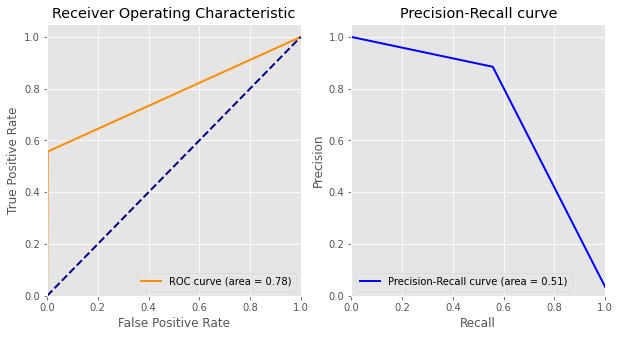

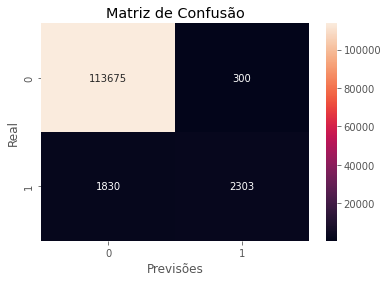

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.88      0.56      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.78      0.84    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 7min 37s, sys: 272 ms, total: 7min 37s
Wall time: 7min 37s


In [105]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [106]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 52.1 s, sys: 42 µs, total: 52.1 s
Wall time: 52.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.683788598574822  0.990718145372146
Threshold: 0.05  0.264448648841609   0.90103408692478
Threshold: 0.1   0.431695010278453   0.95856251958776
Threshold: 0.15  0.551596638655462   0.97621212931757
Threshold: 0.2   0.630646946372875  0.983776521696858
Threshold: 0.25  0.673556504156369  0.987215921588639
Threshold: 0.3   0.697054869852132   0.98912876645047
Threshold: 0.35  0.706156837329877  0.990078818035807
Threshold: 0.4   0.707177814029364  0.990588132482741
Threshold: 0.45  0.697047132311187  0.990688216710593
Threshold: 0.5   0.686826965629149  0.990746915275217
Threshold: 0.55  0.665035927228253  0.990460433220856
Threshold: 0.6   0.638924050632911   0.99007377248843
Threshold: 0.65  0.609180327868852  0.989640007648316
Threshold: 0.7   0.576851381121844  0.989158326639602
Threshold: 0.75    0.5363971233117   0.98853436869618

F1-Score Positivo (Teste): 0.5003282994090611
F1-Score Negativo (Teste): 0.9798923717841446
F1-Score Positivo Médio (Validação Cruzada): 0.42734215994807495
F1-Score Positivo Fold 1: 0.4249726177437021
F1-Score Positivo Fold 2: 0.44394618834080724
F1-Score Positivo Fold 3: 0.45847176079734214
F1-Score Positivo Fold 4: 0.4333333333333333
F1-Score Positivo Fold 5: 0.44470046082949305
F1-Score Positivo Fold 6: 0.4021857923497268
F1-Score Positivo Fold 7: 0.4380069524913094
F1-Score Positivo Fold 8: 0.38768529076396807
F1-Score Positivo Fold 9: 0.42033898305084744
F1-Score Positivo Fold 10: 0.4197802197802198
F1-Score Negativo Médio (Validação Cruzada): 0.9775084579455517
F1-Score Negativo Fold 1: 0.9768814126557752
F1-Score Negativo Fold 2: 0.9781786185657722
F1-Score Negativo Fold 3: 0.978476165324178
F1-Score Negativo Fold 4: 0.9775547927119091
F1-Score Negativo Fold 5: 0.9788169113122968
F1-Score Negativo Fold 6: 0.9759105121768618
F1-Score Negativo Fold 7: 0.9786897491102421
F1-Score 

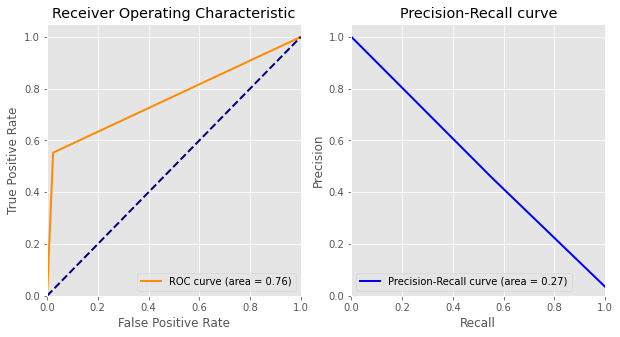

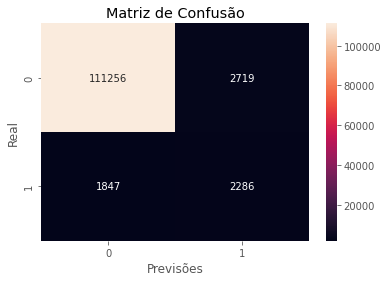

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.46      0.55      0.50      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.76      0.74    118108
weighted avg       0.97      0.96      0.96    118108

CPU times: user 1min 36s, sys: 396 ms, total: 1min 36s
Wall time: 1min 36s


In [107]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [108]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.27 s, sys: 3 µs, total: 1.27 s
Wall time: 1.27 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.500328299409061  0.979892371784145
Threshold: 0.05  0.500328299409061  0.979892371784145
Threshold: 0.1   0.500328299409061  0.979892371784145
Threshold: 0.15  0.500328299409061  0.979892371784145
Threshold: 0.2   0.500328299409061  0.979892371784145
Threshold: 0.25  0.500328299409061  0.979892371784145
Threshold: 0.3   0.500328299409061  0.979892371784145
Threshold: 0.35  0.500328299409061  0.979892371784145
Threshold: 0.4   0.500328299409061  0.979892371784145
Threshold: 0.45  0.500328299409061  0.979892371784145
Threshold: 0.5   0.500328299409061  0.979892371784145
Threshold: 0.55  0.500328299409061  0.979892371784145
Threshold: 0.6   0.500328299409061  0.979892371784145
Threshold: 0.65  0.500328299409061  0.979892371784145
Threshold: 0.7   0.500328299409061  0.979892371784145
Threshold: 0.75  0.500328299409061  0.979892371784145

0:	learn: 0.6196224	total: 77.9ms	remaining: 312ms
1:	learn: 0.5483330	total: 159ms	remaining: 238ms
2:	learn: 0.4992814	total: 242ms	remaining: 162ms
3:	learn: 0.4665184	total: 319ms	remaining: 79.9ms
4:	learn: 0.4394360	total: 402ms	remaining: 0us
0:	learn: 0.5489121	total: 8.1ms	remaining: 32.4ms
1:	learn: 0.4282033	total: 16.9ms	remaining: 25.4ms
2:	learn: 0.3481399	total: 26.1ms	remaining: 17.4ms
3:	learn: 0.2892116	total: 34.6ms	remaining: 8.65ms
4:	learn: 0.2428837	total: 43.3ms	remaining: 0us
0:	learn: 0.5488396	total: 8.06ms	remaining: 32.2ms
1:	learn: 0.4281673	total: 16.5ms	remaining: 24.8ms
2:	learn: 0.3483177	total: 24.6ms	remaining: 16.4ms
3:	learn: 0.2880872	total: 33.3ms	remaining: 8.32ms
4:	learn: 0.2419084	total: 42.2ms	remaining: 0us
0:	learn: 0.5486576	total: 8.1ms	remaining: 32.4ms
1:	learn: 0.4280185	total: 16.7ms	remaining: 25ms
2:	learn: 0.3481685	total: 25.2ms	remaining: 16.8ms
3:	learn: 0.2892096	total: 33.6ms	remaining: 8.4ms
4:	learn: 0.2427371	total: 42.4ms

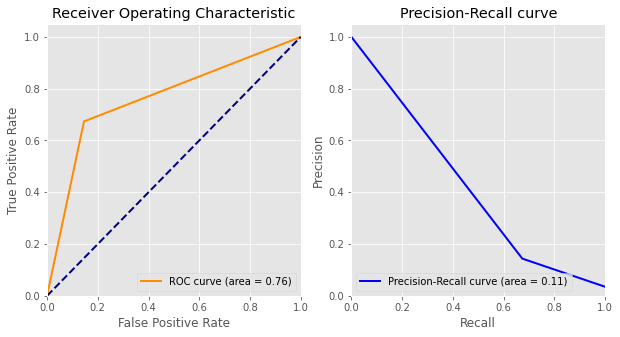

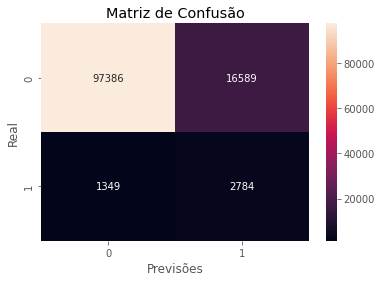

              precision    recall  f1-score   support

           0       0.99      0.85      0.92    113975
           1       0.14      0.67      0.24      4133

    accuracy                           0.85    118108
   macro avg       0.57      0.76      0.58    118108
weighted avg       0.96      0.85      0.89    118108

CPU times: user 55.5 s, sys: 811 ms, total: 56.3 s
Wall time: 37.9 s


In [109]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [110]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 16.7 s, sys: 44.1 ms, total: 16.7 s
Wall time: 16.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.236875691312856  0.915669221005124
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067700224520231  0.003520818371315
Threshold: 0.25  0.076639953069856  0.252346257862358
Threshold: 0.3   0.101030765599182  0.571460721921456
Threshold: 0.35  0.134941044250148  0.752812719424774
Threshold: 0.4    0.15947967789584  0.818370898157968
Threshold: 0.45  0.189061075660893  0.868729894838322
Threshold: 0.5   0.236875691312856  0.915669221005124
Threshold: 0.55  0.300667998071758  0.954193824849455
Threshold: 0.6   0.347895471773389  0.971095097042309
Threshold: 0.65  0.362910270809934  0.977629566657757
Threshold: 0.7   0.263450834879406  0.982800897645846
Threshold: 0.75  0.210766992309291  0.983591538644368

F1-Score Positivo (Teste): 0.31920499887073706
F1-Score Negativo (Teste): 0.9594362431762009
F1-Score Positivo Médio (Validação Cruzada): 0.2857093267224791
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.3897058823529412
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841655912304764
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9856140046797816
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

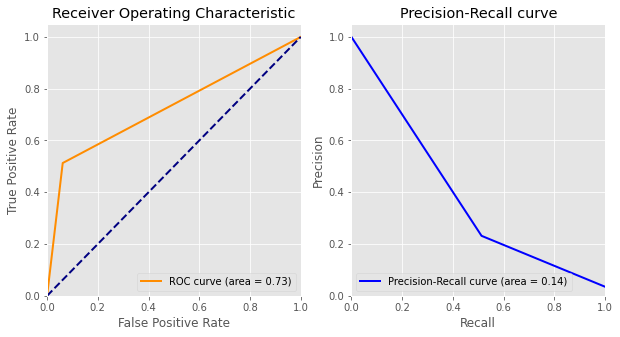

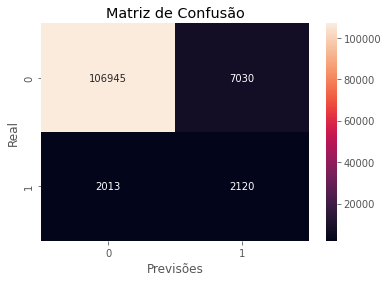

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.51      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 7min 47s, sys: 528 ms, total: 7min 47s
Wall time: 7min 47s


In [111]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [112]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.85 s, sys: 3.99 ms, total: 2.85 s
Wall time: 2.85 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.319204998870737  0.959436243176201
Threshold: 0.05  0.098995190991907  0.566510957143305
Threshold: 0.1    0.12889599059636  0.739069918412931
Threshold: 0.15  0.153908157701335  0.816069265854099
Threshold: 0.2   0.180759749324304  0.863819261702222
Threshold: 0.25  0.206746147135795  0.895430849432689
Threshold: 0.3   0.228469205213391  0.914853011685736
Threshold: 0.35  0.255061952251436  0.931642340152152
Threshold: 0.4   0.275195582144501  0.942421583680632
Threshold: 0.45  0.296860511326003  0.951989435505024
Threshold: 0.5   0.319204998870737  0.959436243176201
Threshold: 0.55  0.337199385979874  0.965379304200633
Threshold: 0.6   0.351359139371818  0.970093664887846
Threshold: 0.65  0.360129310344828  0.973834032502556
Threshold: 0.7   0.364455264759586  0.977100977627291
Threshold: 0.75  0.357750342935528  0.979547976201917

F1-Score Positivo (Teste): 0.30492834673191194
F1-Score Negativo (Teste): 0.9551937488452578
F1-Score Positivo Médio (Validação Cruzada): 0.33560274126687817
F1-Score Positivo Fold 1: 0.39325842696629215
F1-Score Positivo Fold 2: 0.3522727272727273
F1-Score Positivo Fold 3: 0.3403441682600382
F1-Score Positivo Fold 4: 0.32
F1-Score Positivo Fold 5: 0.3474903474903475
F1-Score Positivo Fold 6: 0.3733826247689464
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.26719056974459726
F1-Score Positivo Fold 9: 0.29457364341085274
F1-Score Positivo Fold 10: 0.3213610586011342
F1-Score Negativo Médio (Validação Cruzada): 0.9849291048627661
F1-Score Negativo Fold 1: 0.9859667359667359
F1-Score Negativo Fold 2: 0.9851909586905689
F1-Score Negativo Fold 3: 0.9850642884973376
F1-Score Negativo Fold 4: 0.9845434472009351
F1-Score Negativo Fold 5: 0.9853704986149584
F1-Score Negativo Fold 6: 0.9853125947749231
F1-Score Negativo Fold 7: 0.985282659509999
F1-Score Negativo Fold 

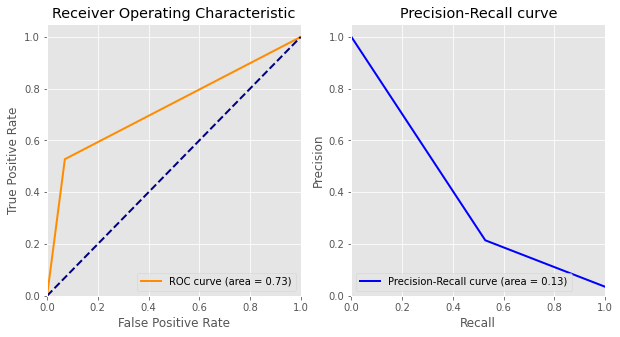

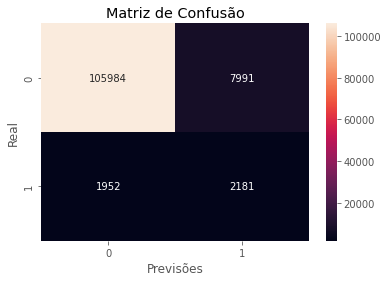

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.21      0.53      0.30      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 9min 25s, sys: 5.27 s, total: 9min 30s
Wall time: 9min 30s


In [113]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [114]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 26 s, sys: 21 µs, total: 26 s
Wall time: 26 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.304928346731912  0.955193748845258
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.304928346731912  0.955193748845258
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.3246813288422165
F1-Score Negativo (Teste): 0.9537487278073052
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score N

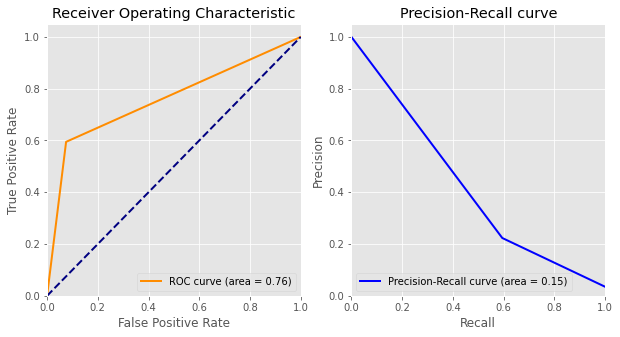

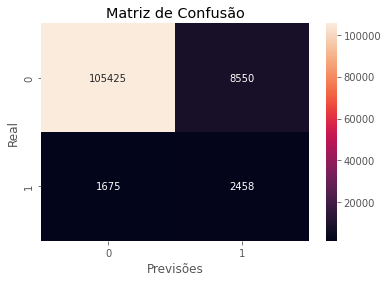

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 37min 33s, sys: 986 ms, total: 37min 34s
Wall time: 3min 38s


In [115]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [116]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 32min 25s, sys: 3.37 s, total: 5h 32min 28s
Wall time: 30min 55s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.324681328842217  0.953748727807305
Threshold: 0.05  0.268039215686275  0.930811431960559
Threshold: 0.1   0.268039215686275  0.930811431960559
Threshold: 0.15  0.268039215686275  0.930811431960559
Threshold: 0.2   0.268039215686275  0.930811431960559
Threshold: 0.25  0.268039215686275  0.930811431960559
Threshold: 0.3   0.268039215686275  0.930811431960559
Threshold: 0.35  0.324681328842217  0.953748727807305
Threshold: 0.4   0.324681328842217  0.953748727807305
Threshold: 0.45  0.324681328842217  0.953748727807305
Threshold: 0.5   0.324681328842217  0.953748727807305
Threshold: 0.55  0.324681328842217  0.953748727807305
Threshold: 0.6   0.324681328842217  0.953748727807305
Threshold: 0.65  0.324681328842217  0.953748727807305
Threshold: 0.7   0.402910234981811  0.973133668074941
Threshold: 0.75  0.402910234981811  0.973133668074941

### Todas as colunas

In [117]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

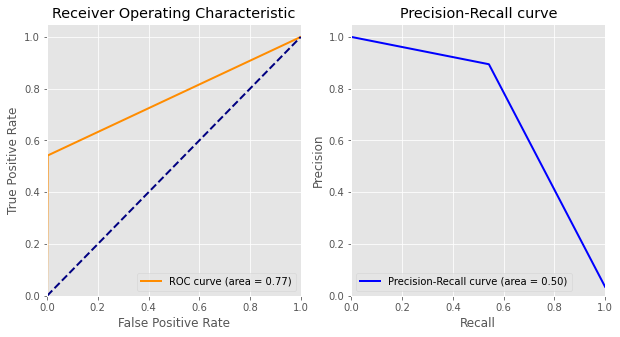

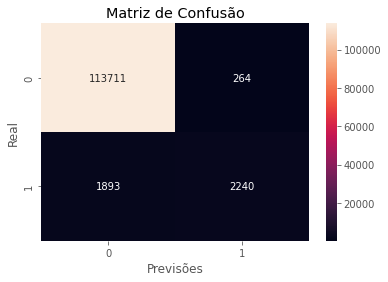

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 57s, sys: 348 ms, total: 8min 57s
Wall time: 8min 57s


In [118]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [119]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 55.3 s, sys: 4.02 ms, total: 55.3 s
Wall time: 55.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675003766762091  0.990604541356135
Threshold: 0.05  0.271667773106144  0.905558053007623
Threshold: 0.1   0.442991732359162  0.960605222720329
Threshold: 0.15  0.565966241818808  0.977560506491425
Threshold: 0.2    0.64401894173358  0.984733026639941
Threshold: 0.25  0.683997689196996  0.987981244589363
Threshold: 0.3   0.708504544888557  0.989740780507045
Threshold: 0.35   0.71462388216728  0.990507934841566
Threshold: 0.4   0.707976814794369  0.990758614665677
Threshold: 0.45  0.697017720789512  0.990827608766765
Threshold: 0.5    0.67941440095608  0.990650133756241
Threshold: 0.55  0.659133126934984  0.990415919497206
Threshold: 0.6   0.632134292565947  0.989993955496802
Threshold: 0.65   0.59973492379059   0.98950386653923
Threshold: 0.7   0.559807791316286  0.988866655960137
Threshold: 0.75  0.522324592487597  0.988307340006592

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

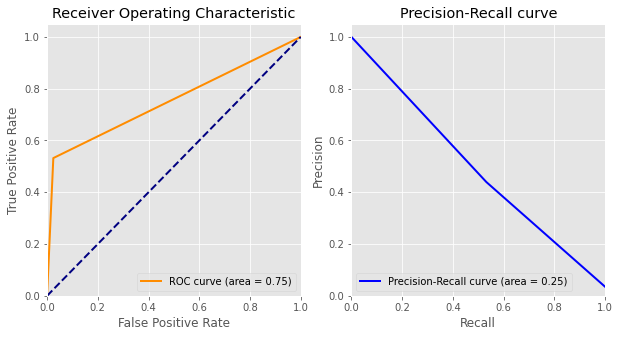

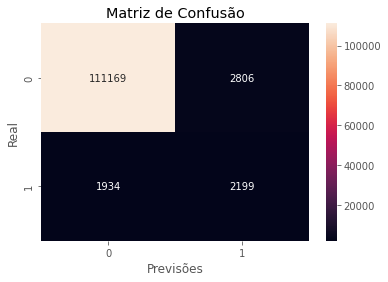

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 2min, sys: 340 ms, total: 2min
Wall time: 2min


In [120]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [121]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.27 s, sys: 1 µs, total: 1.27 s
Wall time: 1.27 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.481286933683519  0.979126115255551
Threshold: 0.05  0.481234270707955  0.979121619538747
Threshold: 0.1   0.481234270707955  0.979121619538747
Threshold: 0.15  0.481234270707955  0.979121619538747
Threshold: 0.2   0.481234270707955  0.979121619538747
Threshold: 0.25  0.481234270707955  0.979121619538747
Threshold: 0.3   0.481234270707955  0.979121619538747
Threshold: 0.35  0.481234270707955  0.979121619538747
Threshold: 0.4   0.481234270707955  0.979121619538747
Threshold: 0.45  0.481234270707955  0.979121619538747
Threshold: 0.5   0.481234270707955  0.979121619538747
Threshold: 0.55  0.481286933683519  0.979126115255551
Threshold: 0.6   0.481286933683519  0.979126115255551
Threshold: 0.65  0.481286933683519  0.979126115255551
Threshold: 0.7   0.481286933683519  0.979126115255551
Threshold: 0.75  0.481286933683519  0.979126115255551

0:	learn: 0.6057922	total: 85.6ms	remaining: 342ms
1:	learn: 0.5400358	total: 171ms	remaining: 256ms
2:	learn: 0.4834998	total: 252ms	remaining: 168ms
3:	learn: 0.4519096	total: 334ms	remaining: 83.4ms
4:	learn: 0.4196478	total: 416ms	remaining: 0us
0:	learn: 0.5336608	total: 8.61ms	remaining: 34.5ms
1:	learn: 0.4271318	total: 17.7ms	remaining: 26.5ms
2:	learn: 0.3416706	total: 26.6ms	remaining: 17.8ms
3:	learn: 0.2888256	total: 35.2ms	remaining: 8.79ms
4:	learn: 0.2438958	total: 44.4ms	remaining: 0us
0:	learn: 0.5331992	total: 8.96ms	remaining: 35.8ms
1:	learn: 0.4266171	total: 18ms	remaining: 27.1ms
2:	learn: 0.3413103	total: 27.3ms	remaining: 18.2ms
3:	learn: 0.2883925	total: 35.8ms	remaining: 8.96ms
4:	learn: 0.2434156	total: 45.2ms	remaining: 0us
0:	learn: 0.5334749	total: 8.58ms	remaining: 34.3ms
1:	learn: 0.4268605	total: 17.6ms	remaining: 26.5ms
2:	learn: 0.3408881	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.2880311	total: 35.2ms	remaining: 8.79ms
4:	learn: 0.2431527	total: 44.

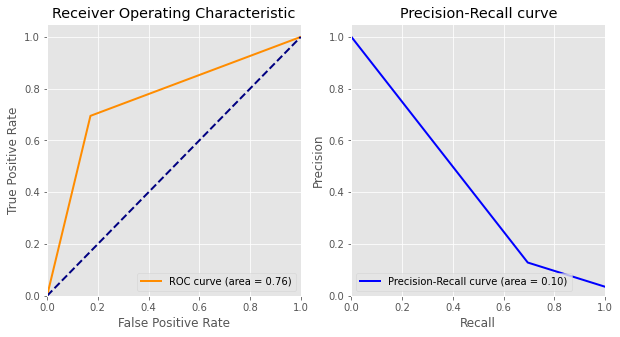

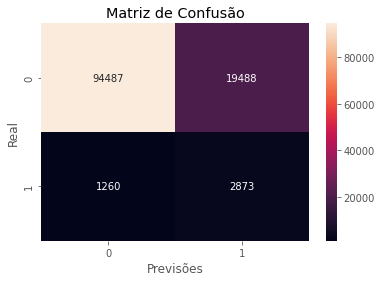

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.70      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.76      0.56    118108
weighted avg       0.96      0.82      0.88    118108

CPU times: user 1min 46s, sys: 983 ms, total: 1min 47s
Wall time: 1min 24s


In [122]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [123]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 40.5 s, sys: 20.2 ms, total: 40.5 s
Wall time: 40.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.216879293424926  0.901069034245334
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.073116393926651   0.16757065143151
Threshold: 0.3   0.090246314482188  0.469937154113123
Threshold: 0.35  0.149614721355133   0.79539928048108
Threshold: 0.4   0.184414814814815  0.864046309009908
Threshold: 0.45  0.197506496924241  0.881472375945622
Threshold: 0.5   0.216879293424926  0.901069034245334
Threshold: 0.55  0.289447109315829  0.948913655092298
Threshold: 0.6    0.34407908875994  0.973099466748931
Threshold: 0.65  0.331574740207834  0.981818656206922
Threshold: 0.7   0.219689526429554  0.982818969657374
Threshold: 0.75  0.193589202867988  0.983479786066686

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

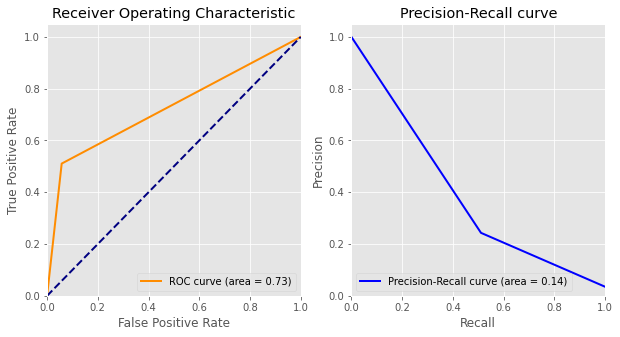

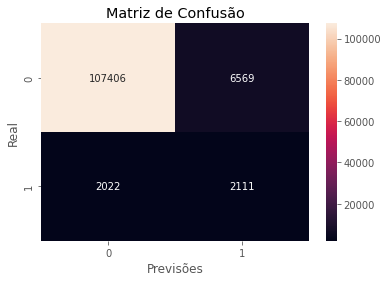

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 9min 11s, sys: 352 ms, total: 9min 11s
Wall time: 9min 11s


In [124]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [125]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.88 s, sys: 1 µs, total: 2.88 s
Wall time: 2.87 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.329509092328104  0.961544831537625
Threshold: 0.05  0.101978875804298  0.589265993349087
Threshold: 0.1   0.135356754235971  0.759147397592448
Threshold: 0.15  0.165249150767502  0.834149485190015
Threshold: 0.2    0.19301494062061  0.876627686781329
Threshold: 0.25  0.221078298564075  0.904339311433175
Threshold: 0.3   0.245376023153801  0.922060877241328
Threshold: 0.35  0.269615587151132   0.93614944804029
Threshold: 0.4   0.290394459500151   0.94634603913283
Threshold: 0.45  0.311019567456231  0.954726123500458
Threshold: 0.5   0.329509092328104  0.961544831537625
Threshold: 0.55  0.342626687708224  0.966647391130288
Threshold: 0.6     0.3524557956778   0.97083650391973
Threshold: 0.65  0.357784103350121  0.974167921719907
Threshold: 0.7   0.361552680221811  0.977286377525745
Threshold: 0.75  0.353623188405797  0.979547628302274

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

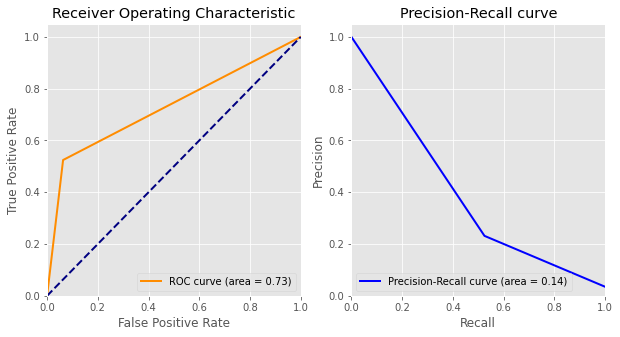

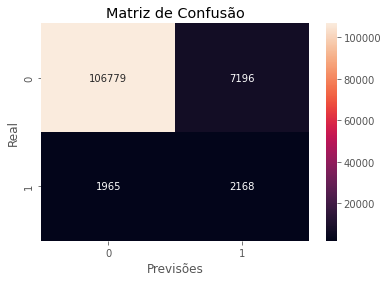

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.52      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 11min 18s, sys: 8.14 s, total: 11min 26s
Wall time: 11min 26s


In [126]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [127]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 35.3 s, sys: 128 ms, total: 35.4 s
Wall time: 35.4 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.321256575535304  0.958867451811475
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.321256575535304  0.958867451811475
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

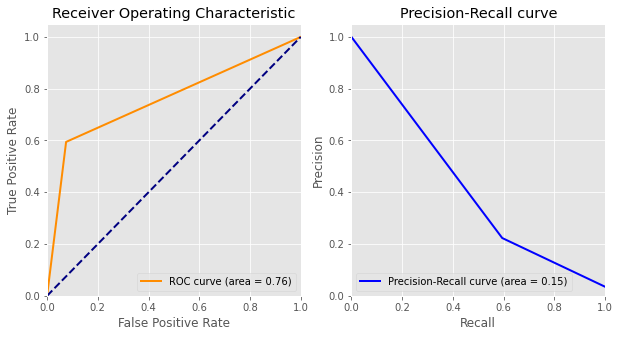

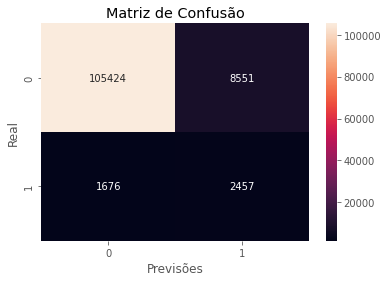

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 49min 34s, sys: 1.35 s, total: 49min 35s
Wall time: 4min 48s


In [128]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [129]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 7h 59min 59s, sys: 5.23 s, total: 8h 4s
Wall time: 44min 38s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.324549237170596  0.953739681103698
Threshold: 0.05  0.268078639015542  0.930826294255835
Threshold: 0.1   0.268078639015542  0.930826294255835
Threshold: 0.15  0.268078639015542  0.930826294255835
Threshold: 0.2   0.268078639015542  0.930826294255835
Threshold: 0.25  0.268078639015542  0.930826294255835
Threshold: 0.3   0.268078639015542  0.930826294255835
Threshold: 0.35  0.324549237170596  0.953739681103698
Threshold: 0.4   0.324549237170596  0.953739681103698
Threshold: 0.45  0.324549237170596  0.953739681103698
Threshold: 0.5   0.324549237170596  0.953739681103698
Threshold: 0.55  0.324549237170596  0.953739681103698
Threshold: 0.6   0.324549237170596  0.953739681103698
Threshold: 0.65  0.324549237170596  0.953739681103698
Threshold: 0.7    0.40290737648561  0.973105934921583
Threshold: 0.75   0.40290737648561  0.973105934921583

In [130]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.2e+04 s


## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [131]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6117548513192796
F1-Score Negativo (Teste): 0.9878587051905018
F1-Score Positivo Médio (Validação Cruzada): 0.497380187760667
F1-Score Positivo Fold 1: 0.5024793388429752
F1-Score Positivo Fold 2: 0.5032894736842105
F1-Score Positivo Fold 3: 0.5199362041467306
F1-Score Positivo Fold 4: 0.5016393442622951
F1-Score Positivo Fold 5: 0.5377049180327869
F1-Score Positivo Fold 6: 0.5056726094003242
F1-Score Positivo Fold 7: 0.4694214876033059
F1-Score Positivo Fold 8: 0.46700507614213194
F1-Score Positivo Fold 9: 0.4747967479674798
F1-Score Positivo Fold 10: 0.4918566775244299
F1-Score Negativo Médio (Validação Cruzada): 0.986676196088756
F1-Score Negativo Fold 1: 0.9869227093018204
F1-Score Negativo Fold 2: 0.9868775527939515
F1-Score Negativo Fold 3: 0.9869101978691021
F1-Score Negativo Fold 4: 0.9867895011298453
F1-Score Negativo Fold 5: 0.987745524074396
F1-Score Negativo Fold 6: 0.9867420126059552
F1-Score Negativo Fold 7: 0.9860537863318418
F1-Score Negativ

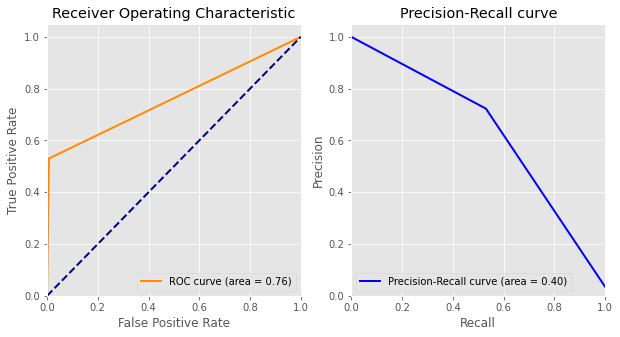

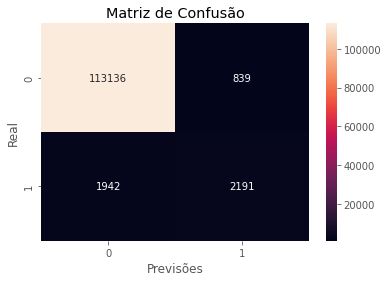

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.72      0.53      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.85      0.76      0.80    118108
weighted avg       0.97      0.98      0.97    118108

CPU times: user 5min 59s, sys: 364 ms, total: 5min 59s
Wall time: 5min 59s


In [132]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [133]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 55.2 s, sys: 22 µs, total: 55.2 s
Wall time: 55.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.61175485131928  0.987858705190502
Threshold: 0.05  0.247943384703811  0.899534022142346
Threshold: 0.1   0.366551077255415  0.949031446540881
Threshold: 0.15  0.460004498088312  0.967681725794945
Threshold: 0.2   0.528139305268827  0.976643341108519
Threshold: 0.25  0.568237205523964  0.981216426350014
Threshold: 0.3   0.595039483928373  0.983976235009352
Threshold: 0.35   0.61091864771234    0.9857051943207
Threshold: 0.4    0.62131748640789  0.986881698765259
Threshold: 0.45  0.619407938404354  0.987462994625748
Threshold: 0.5   0.610628019323672  0.987679662490009
Threshold: 0.55  0.599971251976427  0.987860890957389
Threshold: 0.6   0.592976737294414  0.988028779737391
Threshold: 0.65  0.576375057453654  0.987961983377524
Threshold: 0.7   0.551013941698352  0.987673115735263
Threshold: 0.75  0.519697964543664  0.987285115850585

F1-Score Positivo (Teste): 0.4721369021500659
F1-Score Negativo (Teste): 0.9788110964332892
F1-Score Positivo Médio (Validação Cruzada): 0.419820126647124
F1-Score Positivo Fold 1: 0.45622119815668205
F1-Score Positivo Fold 2: 0.39687848383500557
F1-Score Positivo Fold 3: 0.4444444444444445
F1-Score Positivo Fold 4: 0.4342723004694836
F1-Score Positivo Fold 5: 0.400895856662934
F1-Score Positivo Fold 6: 0.4429378531073446
F1-Score Positivo Fold 7: 0.40373395565927656
F1-Score Positivo Fold 8: 0.38039673278879815
F1-Score Positivo Fold 9: 0.4250871080139373
F1-Score Positivo Fold 10: 0.41333333333333333
F1-Score Negativo Médio (Validação Cruzada): 0.9776980168153344
F1-Score Negativo Fold 1: 0.9792563944800914
F1-Score Negativo Fold 2: 0.9761936193619362
F1-Score Negativo Fold 3: 0.9786803815552333
F1-Score Negativo Fold 4: 0.9788317962231005
F1-Score Negativo Fold 5: 0.9764617889040432
F1-Score Negativo Fold 6: 0.9783172802040727
F1-Score Negativo Fold 7: 0.9775532615857676
F1-Score Ne

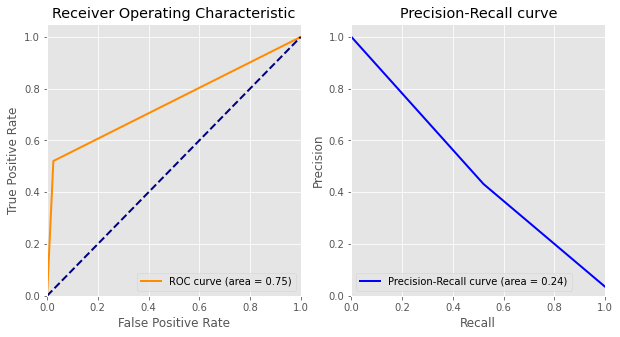

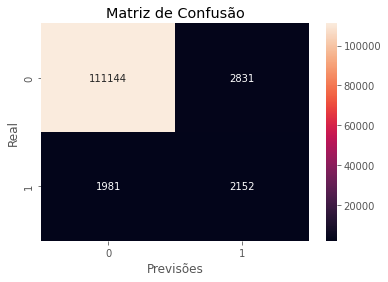

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.43      0.52      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 55.8 s, sys: 320 ms, total: 56.1 s
Wall time: 55.8 s


In [134]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [135]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.472136902150066  0.978811096433289
Threshold: 0.05  0.451586149699357  0.976651807388445
Threshold: 0.1   0.457587876236582  0.977266511993084
Threshold: 0.15  0.463097269624573  0.977808146711338
Threshold: 0.2   0.464304827143316  0.977939199464017
Threshold: 0.25  0.466121746612175  0.978124256339294
Threshold: 0.3   0.467781975175391  0.978272843036603
Threshold: 0.35  0.469184027777778  0.978449339207048
Threshold: 0.4   0.469184027777778  0.978449339207048
Threshold: 0.45  0.469591659426586   0.97848533972371
Threshold: 0.5   0.469591659426586   0.97848533972371
Threshold: 0.55  0.472396004829327  0.978833579181436
Threshold: 0.6   0.472396004829327  0.978833579181436
Threshold: 0.65  0.472655392049198  0.978856060939633
Threshold: 0.7   0.473007146783947   0.97889671144456
Threshold: 0.75  0.473007146783947   0.97889671144456

0:	learn: 0.6119678	total: 71.4ms	remaining: 285ms
1:	learn: 0.5528722	total: 140ms	remaining: 209ms
2:	learn: 0.5073385	total: 209ms	remaining: 139ms
3:	learn: 0.4603233	total: 276ms	remaining: 68.9ms
4:	learn: 0.4273282	total: 344ms	remaining: 0us
0:	learn: 0.5424156	total: 7ms	remaining: 28ms
1:	learn: 0.4303730	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3508018	total: 21.9ms	remaining: 14.6ms
3:	learn: 0.2955985	total: 28.5ms	remaining: 7.11ms
4:	learn: 0.2489750	total: 36.1ms	remaining: 0us
0:	learn: 0.5417738	total: 6.98ms	remaining: 27.9ms
1:	learn: 0.4297572	total: 14.5ms	remaining: 21.8ms
2:	learn: 0.3500694	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2950243	total: 28.1ms	remaining: 7.02ms
4:	learn: 0.2485529	total: 35.5ms	remaining: 0us
0:	learn: 0.5421319	total: 6.67ms	remaining: 26.7ms
1:	learn: 0.4300109	total: 14.1ms	remaining: 21.2ms
2:	learn: 0.3502733	total: 21.1ms	remaining: 14.1ms
3:	learn: 0.2951503	total: 27.8ms	remaining: 6.94ms
4:	learn: 0.2486259	total: 35.4ms

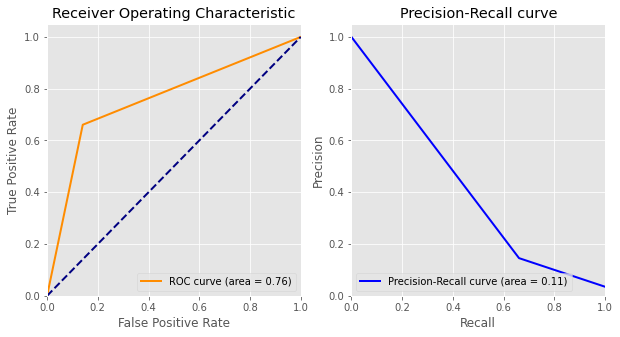

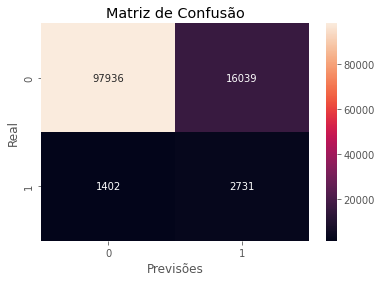

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    113975
           1       0.15      0.66      0.24      4133

    accuracy                           0.85    118108
   macro avg       0.57      0.76      0.58    118108
weighted avg       0.96      0.85      0.89    118108

CPU times: user 21.2 s, sys: 664 ms, total: 21.8 s
Wall time: 9.42 s


In [136]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [137]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.18 s, sys: 36 ms, total: 2.22 s
Wall time: 1.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.238484041391957  0.918237519513579
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.071086559358576  0.111329241321041
Threshold: 0.25  0.080499082274355  0.328437584698893
Threshold: 0.3   0.113217377978699  0.661519293874041
Threshold: 0.35  0.143287051449681  0.780469385692937
Threshold: 0.4   0.163034585347713  0.827655566389798
Threshold: 0.45  0.198614167022429  0.881403542876582
Threshold: 0.5   0.238484041391957  0.918237519513579
Threshold: 0.55  0.270821902776254  0.939033900637644
Threshold: 0.6   0.327298294955177    0.9659577117747
Threshold: 0.65  0.343323483889123  0.979629783203628
Threshold: 0.7   0.250323534849325  0.982431208758833
Threshold: 0.75  0.182883448420172  0.983127157714626

F1-Score Positivo (Teste): 0.3121370707577604
F1-Score Negativo (Teste): 0.9568311985134995
F1-Score Positivo Médio (Validação Cruzada): 0.31873721061362964
F1-Score Positivo Fold 1: 0.43351548269581053
F1-Score Positivo Fold 2: 0.3763837638376384
F1-Score Positivo Fold 3: 0.40074211502782936
F1-Score Positivo Fold 4: 0.3574144486692015
F1-Score Positivo Fold 5: 0.3864915572232645
F1-Score Positivo Fold 6: 0.3868613138686131
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.3085714285714286
F1-Score Positivo Fold 9: 0.33396584440227706
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9846091359786404
F1-Score Negativo Fold 1: 0.9865210419104581
F1-Score Negativo Fold 2: 0.9853552859618718
F1-Score Negativo Fold 3: 0.9860070181518867
F1-Score Negativo Fold 4: 0.9853654312435053
F1-Score Negativo Fold 5: 0.9858374117545152
F1-Score Negativo Fold 6: 0.9854381554996966
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score

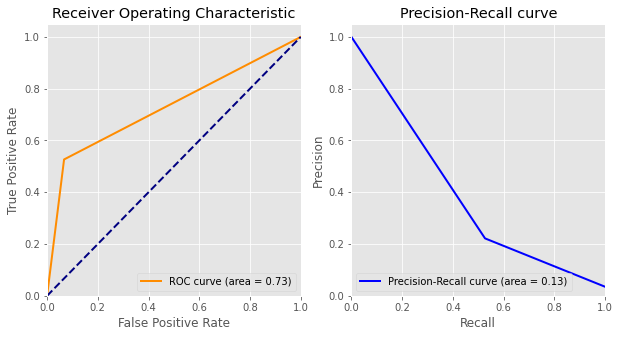

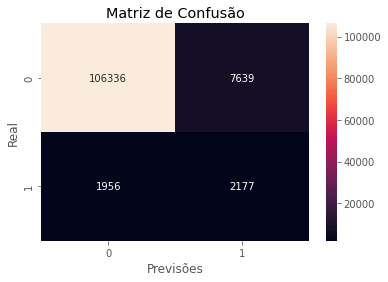

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.53      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 5min 32s, sys: 316 ms, total: 5min 32s
Wall time: 5min 32s


In [138]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [139]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.42 s, sys: 1 µs, total: 2.42 s
Wall time: 2.42 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.31213707075776    0.9568311985135
Threshold: 0.05   0.09153066242068  0.485444490126126
Threshold: 0.1    0.12091368719224  0.695837488247528
Threshold: 0.15  0.152016591651222   0.79866102298682
Threshold: 0.2   0.174381112265835  0.844062831862861
Threshold: 0.25   0.20269638924114            0.88416
Threshold: 0.3   0.229028388644542  0.908705245116142
Threshold: 0.35  0.247010119595216  0.923674443760607
Threshold: 0.4   0.271456649923564  0.938760899495181
Threshold: 0.45  0.292538814507512  0.948912199793924
Threshold: 0.5    0.31213707075776    0.9568311985135
Threshold: 0.55  0.331367924528302  0.964616838426702
Threshold: 0.6   0.350944115964143  0.969848934567846
Threshold: 0.65  0.360268989086099  0.974452442272557
Threshold: 0.7   0.369422001243008  0.977766674993755
Threshold: 0.75  0.368361899409947   0.98037521060856

F1-Score Positivo (Teste): 0.2985328792245219
F1-Score Negativo (Teste): 0.9515270561399062
F1-Score Positivo Médio (Validação Cruzada): 0.3330686728785571
F1-Score Positivo Fold 1: 0.3726235741444867
F1-Score Positivo Fold 2: 0.35160680529300564
F1-Score Positivo Fold 3: 0.3619402985074627
F1-Score Positivo Fold 4: 0.32504780114722753
F1-Score Positivo Fold 5: 0.3864915572232645
F1-Score Positivo Fold 6: 0.3383458646616541
F1-Score Positivo Fold 7: 0.3110236220472441
F1-Score Positivo Fold 8: 0.2862595419847328
F1-Score Positivo Fold 9: 0.2890625
F1-Score Positivo Fold 10: 0.30828516377649323
F1-Score Negativo Médio (Validação Cruzada): 0.9848728533629896
F1-Score Negativo Fold 1: 0.9857118115691029
F1-Score Negativo Fold 2: 0.9851470142467414
F1-Score Negativo Fold 3: 0.9851858269080828
F1-Score Negativo Fold 4: 0.9847179531581454
F1-Score Negativo Fold 5: 0.9858374117545152
F1-Score Negativo Fold 6: 0.9847553053269813
F1-Score Negativo Fold 7: 0.9848576620230164
F1-Score Negativo Fo

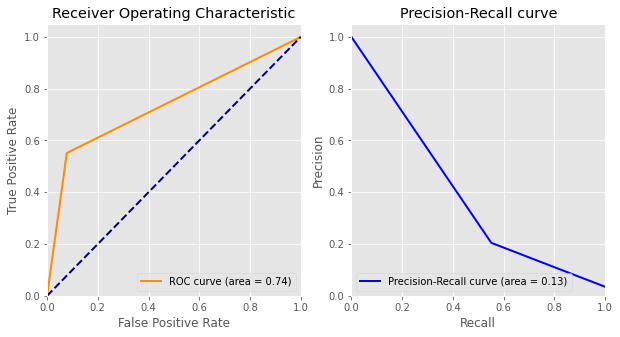

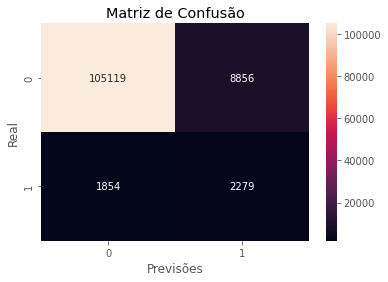

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.20      0.55      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.59      0.74      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 6min 34s, sys: 3.07 s, total: 6min 37s
Wall time: 6min 37s


In [140]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [141]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 17.9 s, sys: 48 ms, total: 18 s
Wall time: 18 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.298532879224522  0.951527056139906
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.298532879224522  0.951527056139906
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.35136413814855705
F1-Score Negativo (Teste): 0.9632002290479301
F1-Score Positivo Médio (Validação Cruzada): 0.25627271844116345
F1-Score Positivo Fold 1: 0.2764811490125673
F1-Score Positivo Fold 2: 0.22222222222222224
F1-Score Positivo Fold 3: 0.2486865148861646
F1-Score Positivo Fold 4: 0.23674911660777387
F1-Score Positivo Fold 5: 0.288695652173913
F1-Score Positivo Fold 6: 0.2504347826086956
F1-Score Positivo Fold 7: 0.25473321858864023
F1-Score Positivo Fold 8: 0.24372759856630827
F1-Score Positivo Fold 9: 0.26548672566371684
F1-Score Positivo Fold 10: 0.2755102040816326
F1-Score Negativo Médio (Validação Cruzada): 0.9816018373747978
F1-Score Negativo Fold 1: 0.9825276392802949
F1-Score Negativo Fold 2: 0.9808718282368251
F1-Score Negativo Fold 3: 0.9813890937486444
F1-Score Negativo Fold 4: 0.981263011797363
F1-Score Negativo Fold 5: 0.9822536555733935
F1-Score Negativo Fold 6: 0.9812990844795418
F1-Score Negativo Fold 7: 0.9812074128727052
F1-Score 

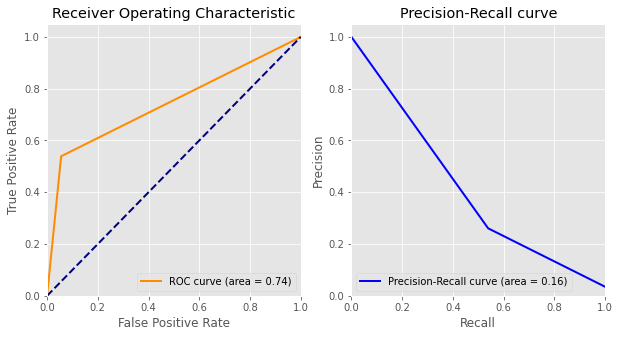

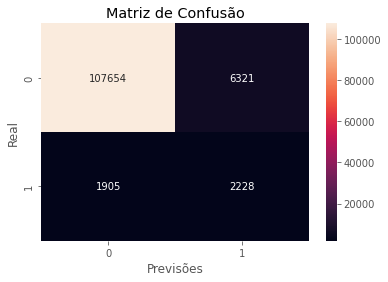

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.26      0.54      0.35      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.74      0.66    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 28min 53s, sys: 1.02 s, total: 28min 54s
Wall time: 2min 48s


In [142]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [143]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 42min 2s, sys: 2.14 s, total: 3h 42min 5s
Wall time: 20min 42s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.351364138148557   0.96320022904793
Threshold: 0.05  0.297115218517879  0.944221815041421
Threshold: 0.1   0.297115218517879  0.944221815041421
Threshold: 0.15  0.297115218517879  0.944221815041421
Threshold: 0.2   0.297115218517879  0.944221815041421
Threshold: 0.25  0.297115218517879  0.944221815041421
Threshold: 0.3   0.297115218517879  0.944221815041421
Threshold: 0.35  0.351364138148557   0.96320022904793
Threshold: 0.4   0.351364138148557   0.96320022904793
Threshold: 0.45  0.351364138148557   0.96320022904793
Threshold: 0.5   0.351364138148557   0.96320022904793
Threshold: 0.55  0.351364138148557   0.96320022904793
Threshold: 0.6   0.351364138148557   0.96320022904793
Threshold: 0.65  0.351364138148557   0.96320022904793
Threshold: 0.7   0.404215610934241  0.976103774872637
Threshold: 0.75  0.404215610934241  0.976103774872637

### 100 Chi-Square

In [144]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.665955501371533
F1-Score Negativo (Teste): 0.9904552065280815
F1-Score Positivo Médio (Validação Cruzada): 0.4929123433233201
F1-Score Positivo Fold 1: 0.5301204819277109
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.4973913043478261
F1-Score Positivo Fold 4: 0.5157894736842106
F1-Score Positivo Fold 5: 0.5214408233276159
F1-Score Positivo Fold 6: 0.5077186963979416
F1-Score Positivo Fold 7: 0.4751773049645391
F1-Score Positivo Fold 8: 0.4667863554757631
F1-Score Positivo Fold 9: 0.4802867383512545
F1-Score Positivo Fold 10: 0.466786355475763
F1-Score Negativo Médio (Validação Cruzada): 0.9875072838760955
F1-Score Negativo Fold 1: 0.9881515559220521
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874604069944027
F1-Score Negativo Fold 4: 0.9880270692347736
F1-Score Negativo Fold 5: 0.9878900993966752
F1-Score Negativo Fold 6: 0.9875428621033898
F1-Score Negativo Fold 7: 0.987162806834938
F1-Score Negativo

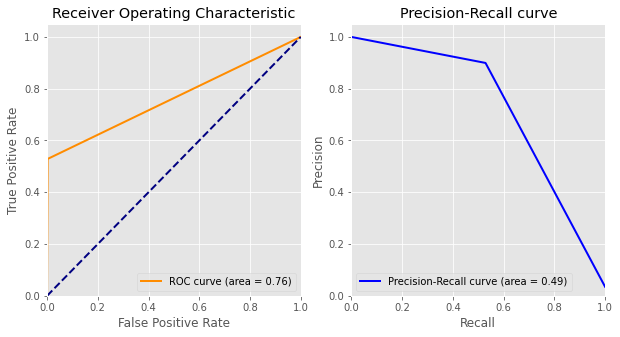

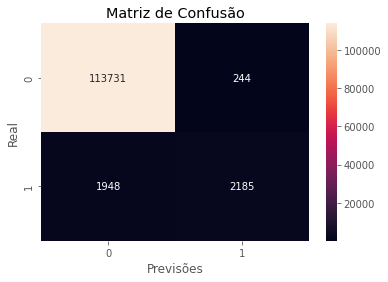

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.53      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 7min 30s, sys: 460 ms, total: 7min 30s
Wall time: 7min 30s


In [145]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [146]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 49.6 s, sys: 72 ms, total: 49.7 s
Wall time: 49.7 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.665955501371533  0.990455206528081
Threshold: 0.05  0.276082381238725   0.90810465249418
Threshold: 0.1   0.446528591897877  0.961523485253235
Threshold: 0.15  0.569728783902012  0.978121413255274
Threshold: 0.2   0.639699749791493  0.984750070601525
Threshold: 0.25  0.684609111033438  0.988108051117369
Threshold: 0.3   0.705971277399849  0.989775624457898
Threshold: 0.35  0.707745541655576  0.990397985150983
Threshold: 0.4   0.704799107142857    0.9907617617268
Threshold: 0.45  0.691056910569106  0.990720714435219
Threshold: 0.5   0.670492298399275  0.990496267324059
Threshold: 0.55  0.648107600875821  0.990209814552132
Threshold: 0.6   0.621525533290239  0.989818630775384
Threshold: 0.65  0.588844355377422  0.989306252931876
Threshold: 0.7   0.550604490500864  0.988707871507556
Threshold: 0.75  0.502246989034694  0.987994953458225

F1-Score Positivo (Teste): 0.46173941438989874
F1-Score Negativo (Teste): 0.9782186416713283
F1-Score Positivo Médio (Validação Cruzada): 0.4267209652930908
F1-Score Positivo Fold 1: 0.43546576879910215
F1-Score Positivo Fold 2: 0.4601571268237935
F1-Score Positivo Fold 3: 0.44071588366890374
F1-Score Positivo Fold 4: 0.4257206208425721
F1-Score Positivo Fold 5: 0.4316877152698049
F1-Score Positivo Fold 6: 0.39436619718309857
F1-Score Positivo Fold 7: 0.4447058823529412
F1-Score Positivo Fold 8: 0.3895809739524349
F1-Score Positivo Fold 9: 0.40934371523915464
F1-Score Positivo Fold 10: 0.43546576879910215
F1-Score Negativo Médio (Validação Cruzada): 0.9775596840605534
F1-Score Negativo Fold 1: 0.9778716290528352
F1-Score Negativo Fold 2: 0.9788394703268664
F1-Score Negativo Fold 3: 0.9780007039774727
F1-Score Negativo Fold 4: 0.9772007042253522
F1-Score Negativo Fold 5: 0.9782427146059514
F1-Score Negativo Fold 6: 0.9753733644653949
F1-Score Negativo Fold 7: 0.9792727911470226
F1-Score

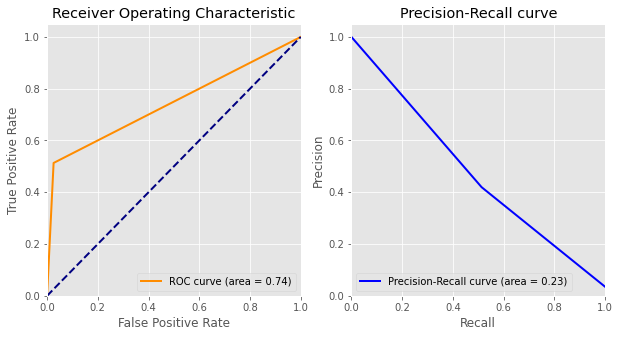

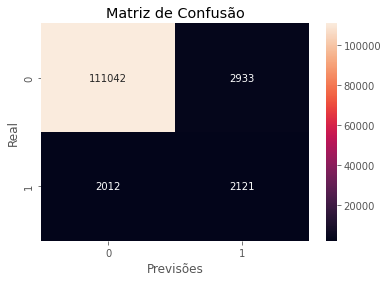

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.42      0.51      0.46      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.74      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 33s, sys: 364 ms, total: 1min 34s
Wall time: 1min 33s


In [147]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [148]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.24 s, sys: 76 ms, total: 1.32 s
Wall time: 1.32 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.461739414389899  0.978218641671328
Threshold: 0.05  0.461689159773618  0.978214140987015
Threshold: 0.1   0.461689159773618  0.978214140987015
Threshold: 0.15  0.461689159773618  0.978214140987015
Threshold: 0.2   0.461689159773618  0.978214140987015
Threshold: 0.25  0.461689159773618  0.978214140987015
Threshold: 0.3   0.461689159773618  0.978214140987015
Threshold: 0.35  0.461689159773618  0.978214140987015
Threshold: 0.4   0.461689159773618  0.978214140987015
Threshold: 0.45  0.461689159773618  0.978214140987015
Threshold: 0.5   0.461689159773618  0.978214140987015
Threshold: 0.55  0.461739414389899  0.978218641671328
Threshold: 0.6   0.461739414389899  0.978218641671328
Threshold: 0.65  0.461739414389899  0.978218641671328
Threshold: 0.7   0.461739414389899  0.978218641671328
Threshold: 0.75  0.461739414389899  0.978218641671328

0:	learn: 0.6132321	total: 81.7ms	remaining: 327ms
1:	learn: 0.5470238	total: 159ms	remaining: 238ms
2:	learn: 0.5037906	total: 233ms	remaining: 155ms
3:	learn: 0.4669084	total: 313ms	remaining: 78.2ms
4:	learn: 0.4279325	total: 392ms	remaining: 0us
0:	learn: 0.5489121	total: 7.93ms	remaining: 31.7ms
1:	learn: 0.4308472	total: 15.7ms	remaining: 23.5ms
2:	learn: 0.3491787	total: 24ms	remaining: 16ms
3:	learn: 0.2883795	total: 32.4ms	remaining: 8.09ms
4:	learn: 0.2435547	total: 40.8ms	remaining: 0us
0:	learn: 0.5488396	total: 7.86ms	remaining: 31.4ms
1:	learn: 0.4309777	total: 15.6ms	remaining: 23.5ms
2:	learn: 0.3493538	total: 24.2ms	remaining: 16.1ms
3:	learn: 0.2883847	total: 32.5ms	remaining: 8.12ms
4:	learn: 0.2447842	total: 40.5ms	remaining: 0us
0:	learn: 0.5486576	total: 8.36ms	remaining: 33.4ms
1:	learn: 0.4308392	total: 16.1ms	remaining: 24.1ms
2:	learn: 0.3491236	total: 24.8ms	remaining: 16.5ms
3:	learn: 0.2882263	total: 33ms	remaining: 8.25ms
4:	learn: 0.2446844	total: 41.1ms	

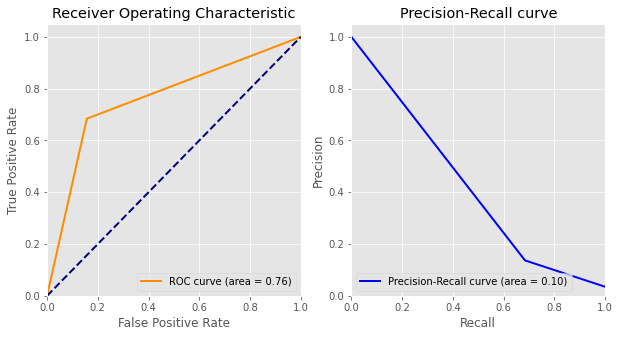

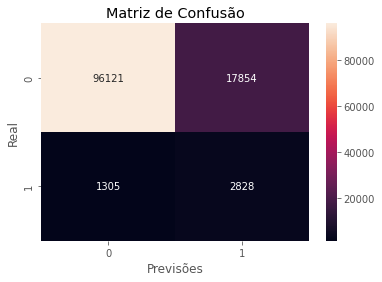

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 54.4 s, sys: 751 ms, total: 55.2 s
Wall time: 37.2 s


In [149]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [150]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 16.2 s, sys: 24 ms, total: 16.3 s
Wall time: 15.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.227926657263752  0.909371289634391
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.070241717665561  0.087585975507465
Threshold: 0.25  0.078470726930834  0.291932115077969
Threshold: 0.3   0.101209327186477  0.583216115899641
Threshold: 0.35  0.148799650807508  0.795153259522259
Threshold: 0.4   0.171037748257267   0.84100483852251
Threshold: 0.45  0.201771686444927  0.884251651712789
Threshold: 0.5   0.227926657263752  0.909371289634391
Threshold: 0.55   0.27909975383894  0.943875083274775
Threshold: 0.6    0.32854893971664  0.967832949600075
Threshold: 0.65  0.345340875260494  0.980836434304438
Threshold: 0.7   0.298387096774194  0.983411336453458
Threshold: 0.75  0.146760687527545  0.983287148542373

F1-Score Positivo (Teste): 0.3261994900718535
F1-Score Negativo (Teste): 0.9609401942912936
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.381651376146789
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9853967153442821
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score Neg

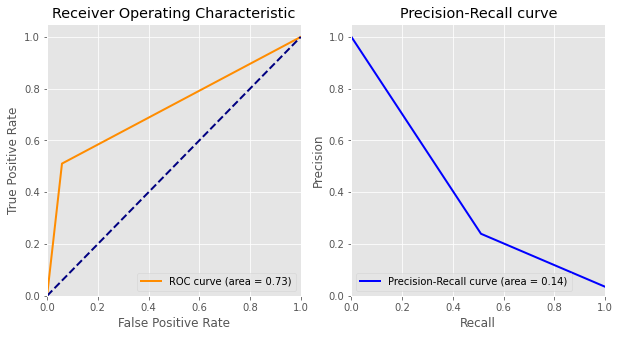

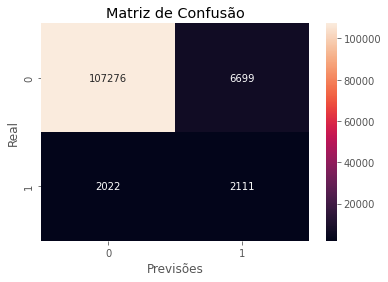

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 7min 55s, sys: 440 ms, total: 7min 55s
Wall time: 7min 55s


In [151]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [152]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.77 s, sys: 92 ms, total: 2.86 s
Wall time: 2.86 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.326199490071854  0.960940194291294
Threshold: 0.05  0.104031568200006   0.60340299747157
Threshold: 0.1   0.135469089627352  0.761548806636817
Threshold: 0.15  0.165727373324069   0.83573422782065
Threshold: 0.2   0.195636553661245  0.880212842537379
Threshold: 0.25  0.222389299988129  0.906843015952025
Threshold: 0.3    0.24735277726175  0.924512306459727
Threshold: 0.35  0.267028811844278  0.936704087123285
Threshold: 0.4    0.29003645200486  0.946822839876954
Threshold: 0.45  0.307734541211996  0.954490288524442
Threshold: 0.5   0.326199490071854  0.960940194291294
Threshold: 0.55  0.341889296315698  0.966462302346482
Threshold: 0.6   0.353507565337001   0.97088985037914
Threshold: 0.65  0.368380491027194  0.974741671179441
Threshold: 0.7   0.367387276096356  0.977551387202406
Threshold: 0.75  0.359157836796477  0.979659225417014

F1-Score Positivo (Teste): 0.31049636193357827
F1-Score Negativo (Teste): 0.9569523466840579
F1-Score Positivo Médio (Validação Cruzada): 0.3324930647429828
F1-Score Positivo Fold 1: 0.39325842696629215
F1-Score Positivo Fold 2: 0.3522727272727273
F1-Score Positivo Fold 3: 0.3403441682600382
F1-Score Positivo Fold 4: 0.29885057471264365
F1-Score Positivo Fold 5: 0.3474903474903475
F1-Score Positivo Fold 6: 0.3733826247689464
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.26719056974459726
F1-Score Positivo Fold 9: 0.2796116504854369
F1-Score Positivo Fold 10: 0.32637571157495254
F1-Score Negativo Médio (Validação Cruzada): 0.9848775721883074
F1-Score Negativo Fold 1: 0.9859667359667359
F1-Score Negativo Fold 2: 0.9851909586905689
F1-Score Negativo Fold 3: 0.9850642884973376
F1-Score Negativo Fold 4: 0.984155844155844
F1-Score Negativo Fold 5: 0.9853704986149584
F1-Score Negativo Fold 6: 0.9853125947749231
F1-Score Negativo Fold 7: 0.985282659509999
F1-Score N

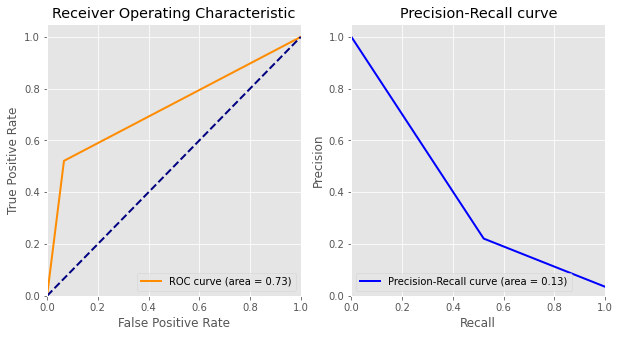

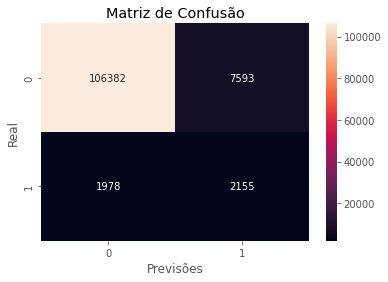

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.52      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 9min 34s, sys: 5.66 s, total: 9min 40s
Wall time: 9min 39s


In [153]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [154]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 24 s, sys: 5.1 s, total: 29.1 s
Wall time: 29.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.310496361933578  0.956952346684058
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.310496361933578  0.956952346684058
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.36950527169505276
F1-Score Negativo (Teste): 0.9652769713157588
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score 

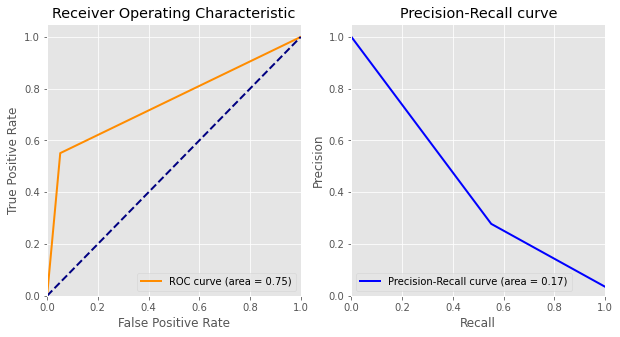

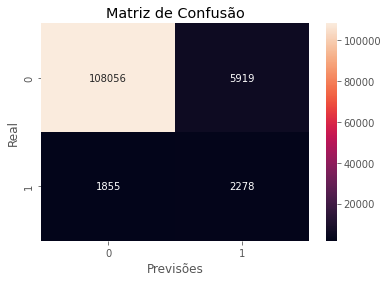

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 37min 54s, sys: 1.19 s, total: 37min 55s
Wall time: 3min 40s


In [155]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [156]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 29min 32s, sys: 3.73 s, total: 5h 29min 36s
Wall time: 32min 31s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.369505271695053  0.965276971315759
Threshold: 0.05  0.309746812496223  0.947998561458936
Threshold: 0.1   0.309746812496223  0.947998561458936
Threshold: 0.15  0.309746812496223  0.947998561458936
Threshold: 0.2   0.309746812496223  0.947998561458936
Threshold: 0.25  0.309746812496223  0.947998561458936
Threshold: 0.3   0.309746812496223  0.947998561458936
Threshold: 0.35  0.369505271695053  0.965276971315759
Threshold: 0.4   0.369505271695053  0.965276971315759
Threshold: 0.45  0.369505271695053  0.965276971315759
Threshold: 0.5   0.369505271695053  0.965276971315759
Threshold: 0.55  0.369505271695053  0.965276971315759
Threshold: 0.6   0.369505271695053  0.965276971315759
Threshold: 0.65  0.369505271695053  0.965276971315759
Threshold: 0.7   0.423200621049129   0.97710817389161
Threshold: 0.75  0.423200621049129   0.97710817389161

### Todas as colunas

In [157]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.663093415007657
F1-Score Negativo (Teste): 0.9904217061553598
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Negat

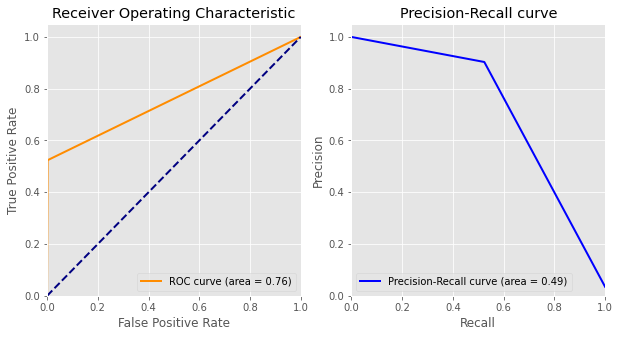

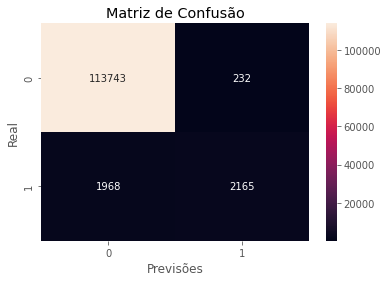

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.52      0.66      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 9min, sys: 356 ms, total: 9min 1s
Wall time: 9min


In [158]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [159]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 54.1 s, sys: 17 µs, total: 54.1 s
Wall time: 54.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.663093415007657   0.99042170615536
Threshold: 0.05  0.281888001234997  0.911523739330972
Threshold: 0.1   0.455616967436905  0.963042328401123
Threshold: 0.15  0.579092772480171  0.979008422409387
Threshold: 0.2   0.651985177342509  0.985505201282351
Threshold: 0.25  0.693607467801016  0.988614859079792
Threshold: 0.3   0.710958381061474  0.990055132488757
Threshold: 0.35  0.716161886893594  0.990741145510024
Threshold: 0.4   0.703766160764474  0.990798777826277
Threshold: 0.45  0.693150284796261  0.990840087370133
Threshold: 0.5   0.668896321070234  0.990515507015389
Threshold: 0.55  0.641990864703103  0.990111673271935
Threshold: 0.6   0.615309446254072  0.989733827083225
Threshold: 0.65  0.585546218487395  0.989290646469735
Threshold: 0.7   0.545580830005209  0.988644302407825
Threshold: 0.75  0.498378378378378  0.987930600955494

F1-Score Positivo (Teste): 0.470433062211475
F1-Score Negativo (Teste): 0.9787863577523578
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score N

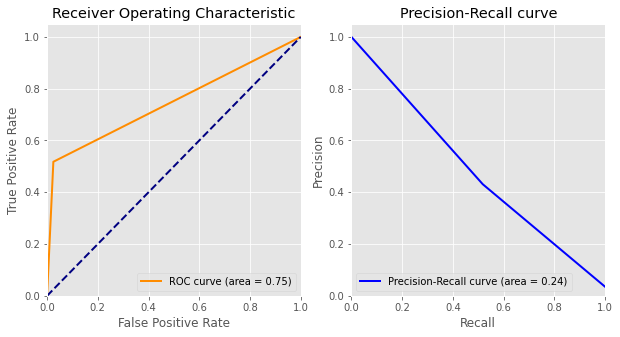

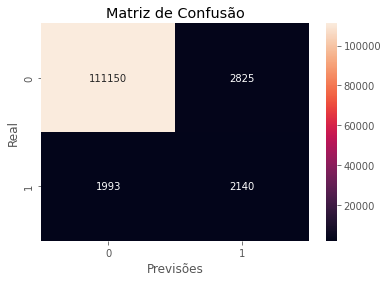

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.43      0.52      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 57s, sys: 348 ms, total: 1min 57s
Wall time: 1min 57s


In [160]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [161]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.470433062211475  0.978786357752358
Threshold: 0.05  0.470433062211475  0.978786357752358
Threshold: 0.1   0.470433062211475  0.978786357752358
Threshold: 0.15  0.470433062211475  0.978786357752358
Threshold: 0.2   0.470433062211475  0.978786357752358
Threshold: 0.25  0.470433062211475  0.978786357752358
Threshold: 0.3   0.470433062211475  0.978786357752358
Threshold: 0.35  0.470433062211475  0.978786357752358
Threshold: 0.4   0.470433062211475  0.978786357752358
Threshold: 0.45  0.470433062211475  0.978786357752358
Threshold: 0.5   0.470433062211475  0.978786357752358
Threshold: 0.55  0.470433062211475  0.978786357752358
Threshold: 0.6   0.470433062211475  0.978786357752358
Threshold: 0.65  0.470433062211475  0.978786357752358
Threshold: 0.7   0.470433062211475  0.978786357752358
Threshold: 0.75  0.470433062211475  0.978786357752358

0:	learn: 0.6171329	total: 87.4ms	remaining: 349ms
1:	learn: 0.5462051	total: 167ms	remaining: 251ms
2:	learn: 0.4978456	total: 250ms	remaining: 167ms
3:	learn: 0.4484678	total: 333ms	remaining: 83.4ms
4:	learn: 0.4161525	total: 415ms	remaining: 0us
0:	learn: 0.5336608	total: 8.89ms	remaining: 35.5ms
1:	learn: 0.4271318	total: 18.2ms	remaining: 27.4ms
2:	learn: 0.3416706	total: 27.4ms	remaining: 18.3ms
3:	learn: 0.2888256	total: 35.8ms	remaining: 8.96ms
4:	learn: 0.2438958	total: 45.1ms	remaining: 0us
0:	learn: 0.5331992	total: 8.81ms	remaining: 35.3ms
1:	learn: 0.4266171	total: 17.8ms	remaining: 26.6ms
2:	learn: 0.3413103	total: 27ms	remaining: 18ms
3:	learn: 0.2883925	total: 35.3ms	remaining: 8.83ms
4:	learn: 0.2434156	total: 44.7ms	remaining: 0us
0:	learn: 0.5334749	total: 8.45ms	remaining: 33.8ms
1:	learn: 0.4268605	total: 17.6ms	remaining: 26.4ms
2:	learn: 0.3408881	total: 26.5ms	remaining: 17.6ms
3:	learn: 0.2880311	total: 34.9ms	remaining: 8.72ms
4:	learn: 0.2431527	total: 44ms	

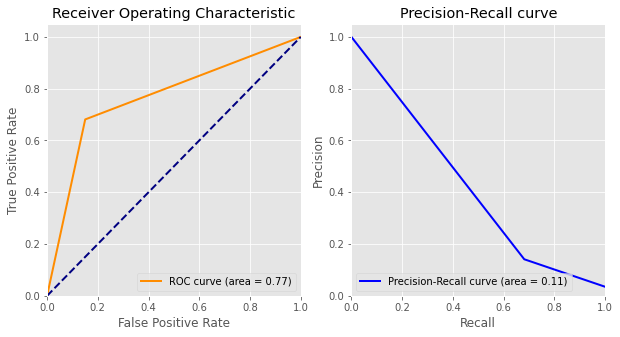

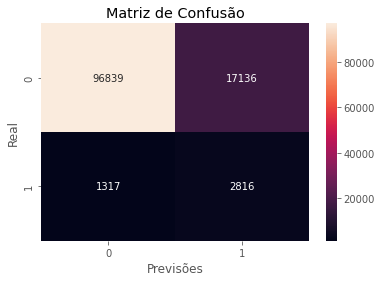

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.77      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 1min 46s, sys: 876 ms, total: 1min 47s
Wall time: 1min 24s


In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [163]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 40.5 s, sys: 40 ms, total: 40.5 s
Wall time: 40.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.233838488685904   0.91301129962146
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.068132502784539  0.017946109502569
Threshold: 0.25  0.075451400803109  0.223468473731355
Threshold: 0.3   0.114250500693268  0.664378363863496
Threshold: 0.35   0.15027437737442  0.799968620067467
Threshold: 0.4   0.178932907169092  0.853975836329276
Threshold: 0.45  0.207168581718402   0.88836623024133
Threshold: 0.5   0.233838488685904   0.91301129962146
Threshold: 0.55  0.280751506557958   0.94448447261617
Threshold: 0.6   0.343003899933416  0.969397836980457
Threshold: 0.65  0.349465558194774  0.980904654000349
Threshold: 0.7   0.236005461283402  0.983049820631878
Threshold: 0.75  0.193371332066709  0.983493103046065

F1-Score Positivo (Teste): 0.3341184114350687
F1-Score Negativo (Teste): 0.9633814642948061
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

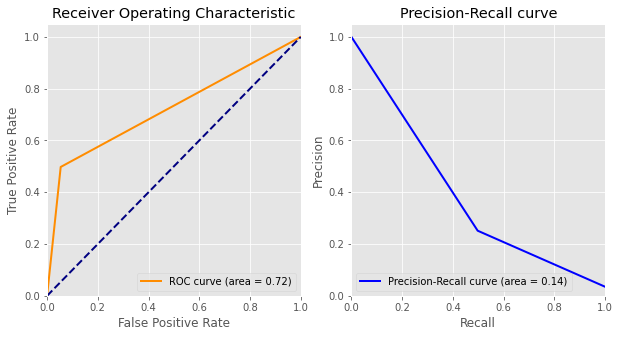

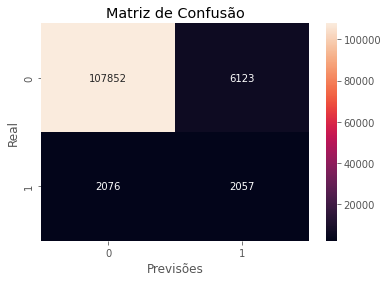

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.25      0.50      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 9min 15s, sys: 360 ms, total: 9min 15s
Wall time: 9min 15s


In [164]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [165]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.89 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334118411435069  0.963381464294806
Threshold: 0.05  0.103403374590512  0.599329899117353
Threshold: 0.1   0.135176291437273  0.760543585197358
Threshold: 0.15  0.167628096369189  0.838867133220485
Threshold: 0.2   0.200477960701009  0.883117891386204
Threshold: 0.25  0.225302318106946  0.908751922394416
Threshold: 0.3   0.249187125960134   0.92589129979767
Threshold: 0.35  0.274617067833698  0.939156449599882
Threshold: 0.4   0.292371288989102  0.948703745743473
Threshold: 0.45  0.312777221347832  0.956776068899108
Threshold: 0.5   0.334118411435069  0.963381464294806
Threshold: 0.55  0.352703199705774  0.968758320759741
Threshold: 0.6   0.367837529789659  0.973071745415223
Threshold: 0.65  0.373172429798097  0.976265169289713
Threshold: 0.7   0.373426754898145  0.978867353145828
Threshold: 0.75  0.363451776649746  0.980860889321083

F1-Score Positivo (Teste): 0.3185745966200199
F1-Score Negativo (Teste): 0.9600652508077925
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

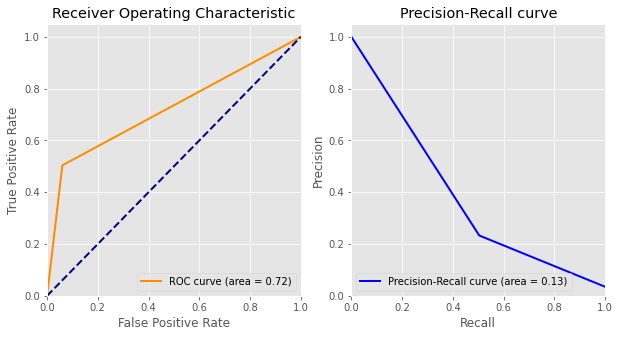

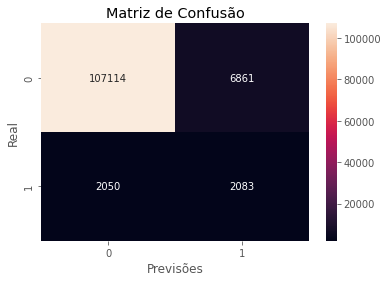

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.50      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.72      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 11min 31s, sys: 8.93 s, total: 11min 40s
Wall time: 11min 39s


In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [167]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 35.5 s, sys: 156 ms, total: 35.6 s
Wall time: 35.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.31857459662002  0.960065250807792
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5    0.31857459662002  0.960065250807792
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.3693854386249392
F1-Score Negativo (Teste): 0.9652584843801646
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

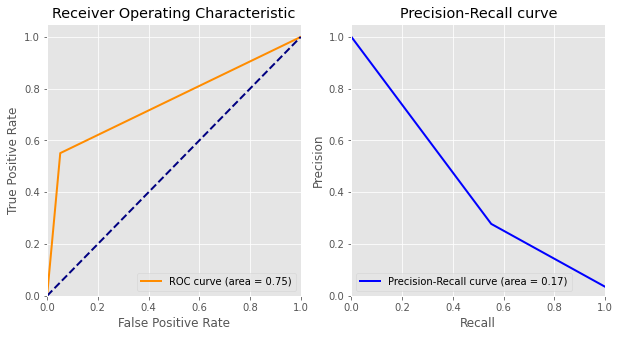

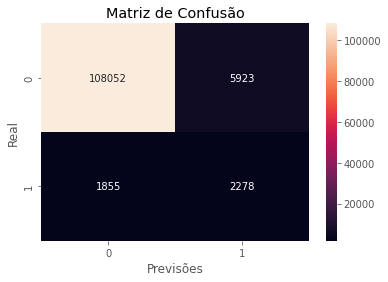

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 49min 48s, sys: 1.64 s, total: 49min 50s
Wall time: 4min 49s


In [168]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [169]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 7h 59min 47s, sys: 5.22 s, total: 7h 59min 53s
Wall time: 44min 38s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.369385438624939  0.965258484380165
Threshold: 0.05  0.309615849238947  0.947965036875171
Threshold: 0.1   0.309615849238947  0.947965036875171
Threshold: 0.15  0.309615849238947  0.947965036875171
Threshold: 0.2   0.309615849238947  0.947965036875171
Threshold: 0.25  0.309615849238947  0.947965036875171
Threshold: 0.3   0.309615849238947  0.947965036875171
Threshold: 0.35  0.369385438624939  0.965258484380165
Threshold: 0.4   0.369385438624939  0.965258484380165
Threshold: 0.45  0.369385438624939  0.965258484380165
Threshold: 0.5   0.369385438624939  0.965258484380165
Threshold: 0.55  0.369385438624939  0.965258484380165
Threshold: 0.6   0.369385438624939  0.965258484380165
Threshold: 0.65  0.369385438624939  0.965258484380165
Threshold: 0.7   0.423213493120284  0.977121881657013
Threshold: 0.75  0.423213493120284  0.977121881657013

In [170]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.3e+04 s


## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [171]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.5977072780591842
F1-Score Negativo (Teste): 0.9868044807051602
F1-Score Positivo Médio (Validação Cruzada): 0.49134581681262574
F1-Score Positivo Fold 1: 0.5149501661129567
F1-Score Positivo Fold 2: 0.4768211920529801
F1-Score Positivo Fold 3: 0.5346534653465346
F1-Score Positivo Fold 4: 0.4851485148514852
F1-Score Positivo Fold 5: 0.5237315875613748
F1-Score Positivo Fold 6: 0.5024630541871922
F1-Score Positivo Fold 7: 0.4657534246575343
F1-Score Positivo Fold 8: 0.4641638225255973
F1-Score Positivo Fold 9: 0.4777594728171335
F1-Score Positivo Fold 10: 0.46801346801346805
F1-Score Negativo Médio (Validação Cruzada): 0.9867294140433678
F1-Score Negativo Fold 1: 0.9873153779322327
F1-Score Negativo Fold 2: 0.986271613519854
F1-Score Negativo Fold 3: 0.9877476538060479
F1-Score Negativo Fold 4: 0.986444212721585
F1-Score Negativo Fold 5: 0.987353874234062
F1-Score Negativo Fold 6: 0.9868335288749837
F1-Score Negativo Fold 7: 0.9864571577393871
F1-Score Negati

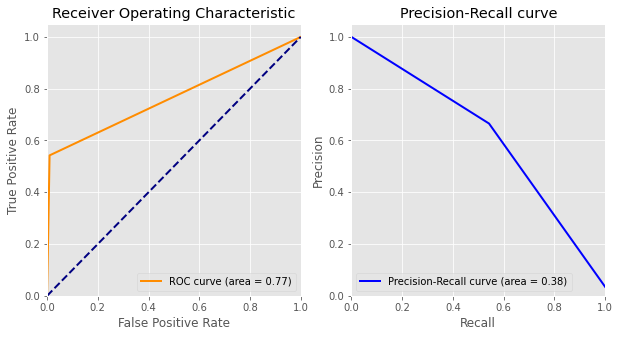

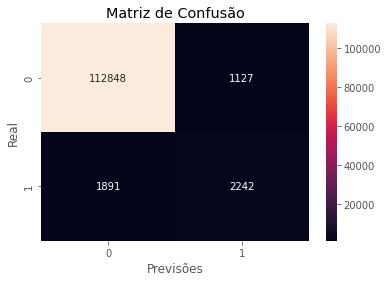

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.67      0.54      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.77      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 5min 44s, sys: 356 ms, total: 5min 44s
Wall time: 5min 44s


In [172]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [173]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 56.8 s, sys: 17 µs, total: 56.8 s
Wall time: 56.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.597707278059184   0.98680448070516
Threshold: 0.05  0.218656029456889  0.874947207134649
Threshold: 0.1   0.332599559735841  0.938305862330503
Threshold: 0.15  0.427695004382121  0.961654688932755
Threshold: 0.2   0.498307603401304  0.972883004689808
Threshold: 0.25  0.543876203057181  0.978574404524462
Threshold: 0.3    0.57920066959615  0.982255203875442
Threshold: 0.35  0.594527643283414  0.984159940176392
Threshold: 0.4   0.602513464991023  0.985425325088541
Threshold: 0.45  0.603940388987118  0.986263567792972
Threshold: 0.5   0.595357425481403  0.986581173403781
Threshold: 0.55  0.590515463917526  0.986987913916686
Threshold: 0.6   0.578458017451008   0.98714363616534
Threshold: 0.65  0.557498518079431  0.986987292345774
Threshold: 0.7   0.532223250077089  0.986793192008009
Threshold: 0.75  0.502641267808548  0.986489483365149

F1-Score Positivo (Teste): 0.43600799242822585
F1-Score Negativo (Teste): 0.9763439152738999
F1-Score Positivo Médio (Validação Cruzada): 0.420420882244818
F1-Score Positivo Fold 1: 0.44786729857819907
F1-Score Positivo Fold 2: 0.38963963963963966
F1-Score Positivo Fold 3: 0.43497267759562835
F1-Score Positivo Fold 4: 0.40774487471526194
F1-Score Positivo Fold 5: 0.4323699421965318
F1-Score Positivo Fold 6: 0.43340857787810383
F1-Score Positivo Fold 7: 0.4071005917159763
F1-Score Positivo Fold 8: 0.40801001251564456
F1-Score Positivo Fold 9: 0.42757009345794394
F1-Score Positivo Fold 10: 0.41552511415525106
F1-Score Negativo Médio (Validação Cruzada): 0.9779656710145332
F1-Score Negativo Fold 1: 0.9795416630081657
F1-Score Negativo Fold 2: 0.9761590569191518
F1-Score Negativo Fold 3: 0.9772316906680759
F1-Score Negativo Fold 4: 0.9771368272951109
F1-Score Negativo Fold 5: 0.9784242211187767
F1-Score Negativo Fold 6: 0.9779204785362421
F1-Score Negativo Fold 7: 0.9780041269701892
F1-Sco

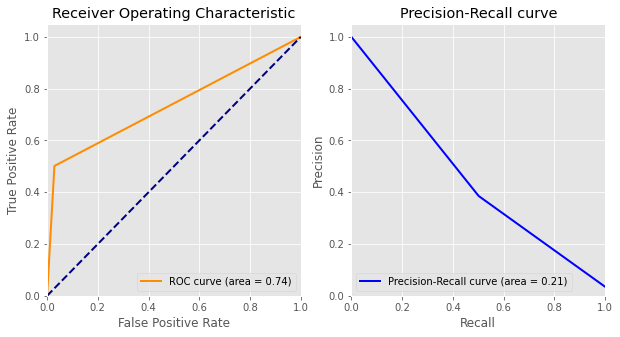

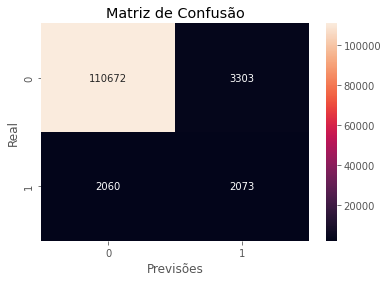

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.39      0.50      0.44      4133

    accuracy                           0.95    118108
   macro avg       0.68      0.74      0.71    118108
weighted avg       0.96      0.95      0.96    118108

CPU times: user 55.8 s, sys: 332 ms, total: 56.2 s
Wall time: 55.8 s


In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [175]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.13 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.436007992428226    0.9763439152739
Threshold: 0.05  0.411198428290766  0.973482100196429
Threshold: 0.1   0.416334661354582  0.974090973401245
Threshold: 0.15  0.421605249873801   0.97468527822333
Threshold: 0.2   0.427415223850015  0.975319599920514
Threshold: 0.25  0.428674277486373   0.97547385570415
Threshold: 0.3    0.43075651095494  0.975686412995498
Threshold: 0.35  0.432118001454243  0.975872615175494
Threshold: 0.4   0.432477388501923  0.975908771960794
Threshold: 0.45  0.432927463835987  0.975953964352381
Threshold: 0.5   0.433288199145922   0.97599011539395
Threshold: 0.55  0.436283278964538  0.976371006514845
Threshold: 0.6   0.437203416640304  0.976461300295943
Threshold: 0.65  0.437387910117101  0.976479357140652
Threshold: 0.7   0.437473595268272  0.976511369449786
Threshold: 0.75  0.437566025776463    0.9765203969129

0:	learn: 0.6057285	total: 72.9ms	remaining: 291ms
1:	learn: 0.5381620	total: 139ms	remaining: 208ms
2:	learn: 0.4848814	total: 207ms	remaining: 138ms
3:	learn: 0.4414786	total: 275ms	remaining: 68.6ms
4:	learn: 0.4184850	total: 340ms	remaining: 0us
0:	learn: 0.5401809	total: 7.45ms	remaining: 29.8ms
1:	learn: 0.4304303	total: 14.6ms	remaining: 21.8ms
2:	learn: 0.3512025	total: 21.8ms	remaining: 14.5ms
3:	learn: 0.2960029	total: 28.9ms	remaining: 7.23ms
4:	learn: 0.2510101	total: 35.7ms	remaining: 0us
0:	learn: 0.5395816	total: 7.31ms	remaining: 29.2ms
1:	learn: 0.4296488	total: 14.6ms	remaining: 22ms
2:	learn: 0.3512542	total: 22.8ms	remaining: 15.2ms
3:	learn: 0.2960457	total: 30ms	remaining: 7.5ms
4:	learn: 0.2507814	total: 36.9ms	remaining: 0us
0:	learn: 0.5397279	total: 7.53ms	remaining: 30.1ms
1:	learn: 0.4298149	total: 14.8ms	remaining: 22.1ms
2:	learn: 0.3514868	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2961449	total: 28.9ms	remaining: 7.22ms
4:	learn: 0.2509767	total: 36.4ms

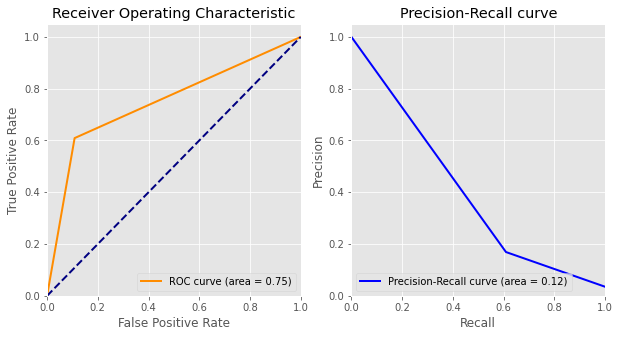

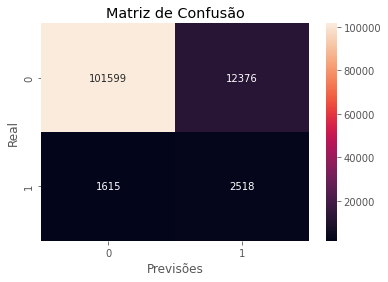

              precision    recall  f1-score   support

           0       0.98      0.89      0.94    113975
           1       0.17      0.61      0.26      4133

    accuracy                           0.88    118108
   macro avg       0.58      0.75      0.60    118108
weighted avg       0.96      0.88      0.91    118108

CPU times: user 21.3 s, sys: 696 ms, total: 22 s
Wall time: 9.49 s


In [176]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [177]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.06 s, sys: 56 ms, total: 2.12 s
Wall time: 1.72 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.264676512324591  0.935581452099324
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067688074746763  0.002138531249726
Threshold: 0.25  0.074420901500672  0.202199188113349
Threshold: 0.3   0.090536783452349   0.47279195896558
Threshold: 0.35  0.133470110976406  0.745570944299319
Threshold: 0.4   0.173591577593828  0.844891822994967
Threshold: 0.45  0.214937306923496  0.896497860575656
Threshold: 0.5   0.264676512324591  0.935581452099324
Threshold: 0.55  0.313511084481726  0.958871778304257
Threshold: 0.6   0.349546922195605  0.972442247865322
Threshold: 0.65  0.362787897034472  0.981561420550326
Threshold: 0.7   0.194671701279631  0.983413192539177
Threshold: 0.75  0.173950670705322  0.983514253391711

F1-Score Positivo (Teste): 0.34653714094296967
F1-Score Negativo (Teste): 0.9652078920967562
F1-Score Positivo Médio (Validação Cruzada): 0.31471213365722306
F1-Score Positivo Fold 1: 0.4241316270566728
F1-Score Positivo Fold 2: 0.37064220183486235
F1-Score Positivo Fold 3: 0.3925233644859813
F1-Score Positivo Fold 4: 0.36432637571157495
F1-Score Positivo Fold 5: 0.37051039697542537
F1-Score Positivo Fold 6: 0.38461538461538464
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.30740037950664134
F1-Score Positivo Fold 9: 0.3295454545454546
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9845271033705286
F1-Score Negativo Fold 1: 0.9863488624052004
F1-Score Negativo Fold 2: 0.9851367162109459
F1-Score Negativo Fold 3: 0.9859228137046824
F1-Score Negativo Fold 4: 0.9854946958216065
F1-Score Negativo Fold 5: 0.9855800459013554
F1-Score Negativo Fold 6: 0.9854394175767031
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Sc

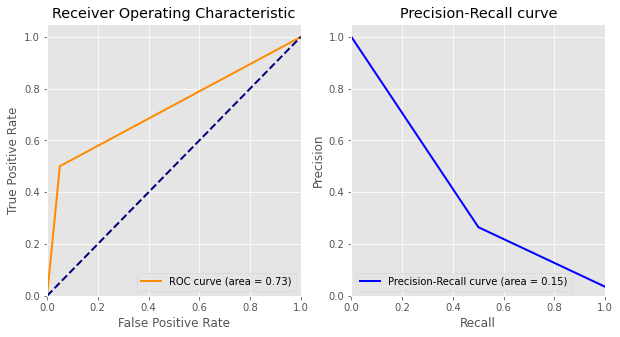

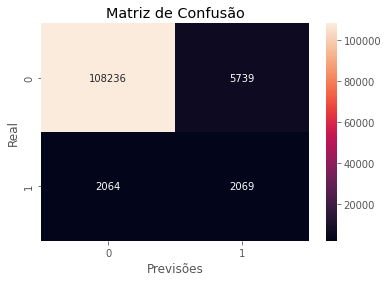

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.26      0.50      0.35      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.73      0.66    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 5min 29s, sys: 324 ms, total: 5min 29s
Wall time: 5min 29s


In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [179]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.52 s, sys: 2 µs, total: 2.52 s
Wall time: 2.52 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.34653714094297  0.965207892096756
Threshold: 0.05  0.086165827342042  0.417668789897212
Threshold: 0.1   0.110665693039059  0.647117607753396
Threshold: 0.15  0.140727441447621  0.771786010876263
Threshold: 0.2   0.167899446542182  0.837134902556315
Threshold: 0.25  0.207815458770873   0.88893715819299
Threshold: 0.3   0.239871744876294  0.917691437901444
Threshold: 0.35  0.267234741543042  0.934136157058159
Threshold: 0.4   0.293630149416248  0.946846621298678
Threshold: 0.45  0.324796274738067  0.958286885540652
Threshold: 0.5    0.34653714094297  0.965207892096756
Threshold: 0.55  0.372247125316702   0.97148977225453
Threshold: 0.6   0.382670676021829  0.975606965414963
Threshold: 0.65   0.38827745072946  0.979071987110446
Threshold: 0.7    0.38598490243555  0.981190689151159
Threshold: 0.75  0.370547073791349  0.982785915590968

F1-Score Positivo (Teste): 0.3213498517899217
F1-Score Negativo (Teste): 0.9599702320910611
F1-Score Positivo Médio (Validação Cruzada): 0.3254469557635342
F1-Score Positivo Fold 1: 0.36704119850187267
F1-Score Positivo Fold 2: 0.3677298311444653
F1-Score Positivo Fold 3: 0.32945736434108525
F1-Score Positivo Fold 4: 0.30947775628626695
F1-Score Positivo Fold 5: 0.3795066413662239
F1-Score Positivo Fold 6: 0.34701492537313433
F1-Score Positivo Fold 7: 0.3037475345167652
F1-Score Positivo Fold 8: 0.2730769230769231
F1-Score Positivo Fold 9: 0.2685370741482966
F1-Score Positivo Fold 10: 0.3088803088803089
F1-Score Negativo Médio (Validação Cruzada): 0.9848102689885148
F1-Score Negativo Fold 1: 0.9853603603603602
F1-Score Negativo Fold 2: 0.9854043050803413
F1-Score Negativo Fold 3: 0.9850255344932053
F1-Score Negativo Fold 4: 0.9845487989612638
F1-Score Negativo Fold 5: 0.9858410911452695
F1-Score Negativo Fold 6: 0.9848392965433596
F1-Score Negativo Fold 7: 0.9847285312567597
F1-Score N

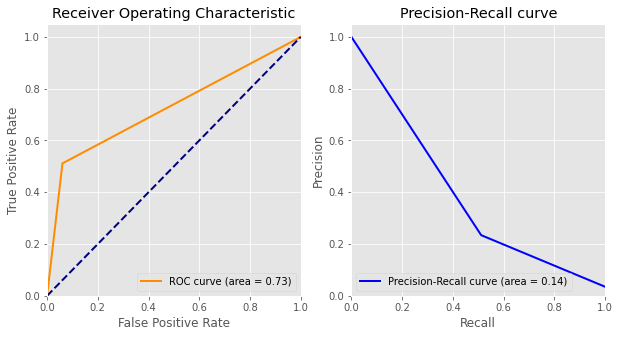

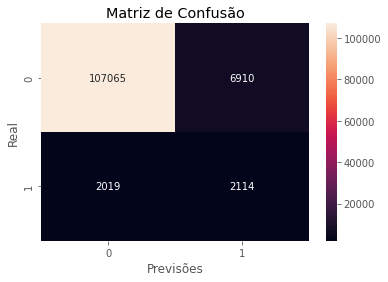

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.51      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 6min 37s, sys: 2.69 s, total: 6min 39s
Wall time: 6min 39s


In [180]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [181]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 17.8 s, sys: 48 ms, total: 17.8 s
Wall time: 17.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.321349851789922  0.959970232091061
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.321349851789922  0.959970232091061
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.32233766233766237
F1-Score Negativo (Teste): 0.9527389319614521
F1-Score Positivo Médio (Validação Cruzada): 0.26549992339671674
F1-Score Positivo Fold 1: 0.2624113475177305
F1-Score Positivo Fold 2: 0.24956063268892795
F1-Score Positivo Fold 3: 0.27526132404181186
F1-Score Positivo Fold 4: 0.23404255319148934
F1-Score Positivo Fold 5: 0.2876949740034662
F1-Score Positivo Fold 6: 0.25125628140703515
F1-Score Positivo Fold 7: 0.27177700348432055
F1-Score Positivo Fold 8: 0.24242424242424243
F1-Score Positivo Fold 9: 0.27681660899653976
F1-Score Positivo Fold 10: 0.30375426621160406
F1-Score Negativo Médio (Validação Cruzada): 0.9816983821514
F1-Score Negativo Fold 1: 0.9819585393355886
F1-Score Negativo Fold 2: 0.981477464972021
F1-Score Negativo Fold 3: 0.9819507115584866
F1-Score Negativo Fold 4: 0.981264637002342
F1-Score Negativo Fold 5: 0.9821653287047083
F1-Score Negativo Fold 6: 0.980586319218241
F1-Score Negativo Fold 7: 0.9818639361332872
F1-Score N

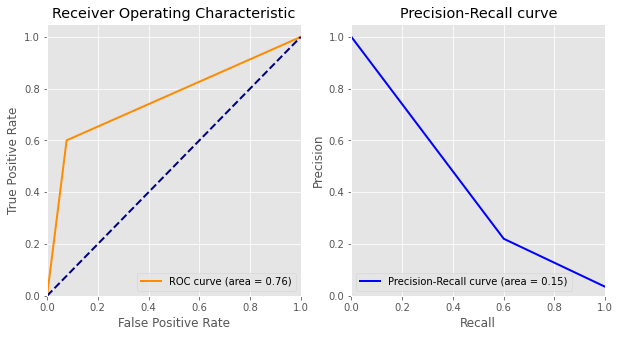

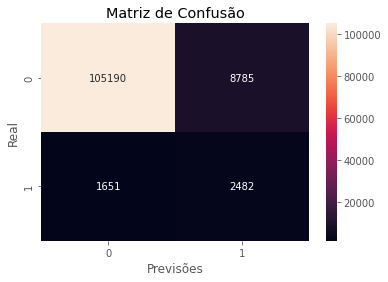

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 28min 47s, sys: 786 ms, total: 28min 48s
Wall time: 2min 47s


In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [183]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 42min 2s, sys: 2.56 s, total: 3h 42min 5s
Wall time: 20min 41s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.322337662337662  0.952738931961452
Threshold: 0.05  0.267511642421624  0.929164712819251
Threshold: 0.1   0.267511642421624  0.929164712819251
Threshold: 0.15  0.267511642421624  0.929164712819251
Threshold: 0.2   0.267511642421624  0.929164712819251
Threshold: 0.25  0.267511642421624  0.929164712819251
Threshold: 0.3   0.267511642421624  0.929164712819251
Threshold: 0.35  0.322337662337662  0.952738931961452
Threshold: 0.4   0.322337662337662  0.952738931961452
Threshold: 0.45  0.322337662337662  0.952738931961452
Threshold: 0.5   0.322337662337662  0.952738931961452
Threshold: 0.55  0.322337662337662  0.952738931961452
Threshold: 0.6   0.322337662337662  0.952738931961452
Threshold: 0.65  0.322337662337662  0.952738931961452
Threshold: 0.7   0.397167248738844   0.97249322733148
Threshold: 0.75  0.397167248738844   0.97249322733148

### 100 Chi-Square

In [184]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6752315506423664
F1-Score Negativo (Teste): 0.9905281410932285
F1-Score Positivo Médio (Validação Cruzada): 0.5004082584961809
F1-Score Positivo Fold 1: 0.5385934819897085
F1-Score Positivo Fold 2: 0.4601449275362319
F1-Score Positivo Fold 3: 0.5154639175257733
F1-Score Positivo Fold 4: 0.5157894736842106
F1-Score Positivo Fold 5: 0.5308219178082192
F1-Score Positivo Fold 6: 0.5212947189097104
F1-Score Positivo Fold 7: 0.4797178130511464
F1-Score Positivo Fold 8: 0.48214285714285715
F1-Score Positivo Fold 9: 0.48324514991181655
F1-Score Positivo Fold 10: 0.47686832740213525
F1-Score Negativo Médio (Validação Cruzada): 0.9876271616696753
F1-Score Negativo Fold 1: 0.9883241460132818
F1-Score Negativo Fold 2: 0.9870827915041179
F1-Score Negativo Fold 3: 0.9877604166666666
F1-Score Negativo Fold 4: 0.9880270692347736
F1-Score Negativo Fold 5: 0.9881066064762566
F1-Score Negativo Fold 6: 0.9878011721293684
F1-Score Negativo Fold 7: 0.9872045109520712
F1-Score Ne

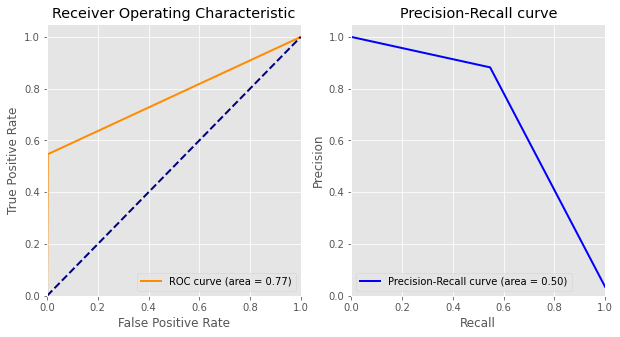

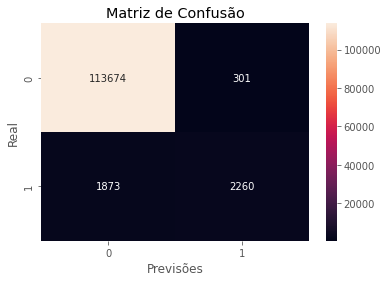

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.88      0.55      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 7min 6s, sys: 340 ms, total: 7min 6s
Wall time: 7min 6s


In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [186]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 51.2 s, sys: 40 ms, total: 51.3 s
Wall time: 51.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675231550642366  0.990528141093229
Threshold: 0.05   0.26364543252102  0.900705267405884
Threshold: 0.1   0.430864580105361  0.958274453496667
Threshold: 0.15  0.548268362054543  0.975921020948712
Threshold: 0.2   0.628065942903096  0.983647709795464
Threshold: 0.25  0.674271515699119  0.987315382517747
Threshold: 0.3   0.695238095238095  0.989053879820722
Threshold: 0.35  0.703353619059951  0.989973434634759
Threshold: 0.4   0.704041366172268  0.990496664001363
Threshold: 0.45  0.695305832147937  0.990653879381812
Threshold: 0.5   0.681191640729213  0.990626184800561
Threshold: 0.55  0.655570966250578    0.9902710608679
Threshold: 0.6    0.62962962962963  0.989910937934873
Threshold: 0.65  0.599603567888999  0.989468287553984
Threshold: 0.7   0.564356435643564  0.988921591609582
Threshold: 0.75  0.523229111464406  0.988293465767387

F1-Score Positivo (Teste): 0.48680978318914886
F1-Score Negativo (Teste): 0.9788188827125935
F1-Score Positivo Médio (Validação Cruzada): 0.4246916488827849
F1-Score Positivo Fold 1: 0.42793791574279383
F1-Score Positivo Fold 2: 0.4444444444444445
F1-Score Positivo Fold 3: 0.4529147982062781
F1-Score Positivo Fold 4: 0.4204671857619577
F1-Score Positivo Fold 5: 0.43800695249130933
F1-Score Positivo Fold 6: 0.40909090909090906
F1-Score Positivo Fold 7: 0.4413793103448275
F1-Score Positivo Fold 8: 0.3670745272525028
F1-Score Positivo Fold 9: 0.42129105322763305
F1-Score Positivo Fold 10: 0.4243093922651934
F1-Score Negativo Médio (Validação Cruzada): 0.9774393912290528
F1-Score Negativo Fold 1: 0.9772887323943663
F1-Score Negativo Fold 2: 0.9786803815552333
F1-Score Negativo Fold 3: 0.9785305763308403
F1-Score Negativo Fold 4: 0.9770716894776218
F1-Score Negativo Fold 5: 0.9786897491102421
F1-Score Negativo Fold 6: 0.9759450171821306
F1-Score Negativo Fold 7: 0.9786392405063291
F1-Score 

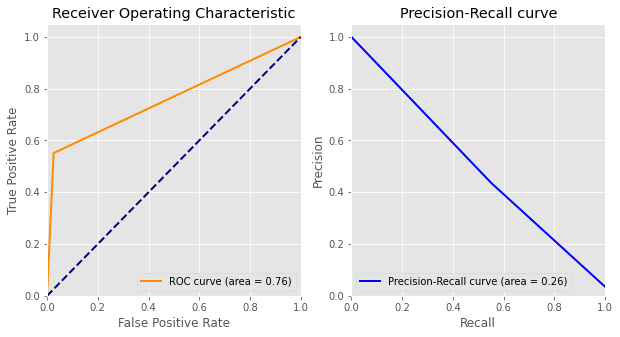

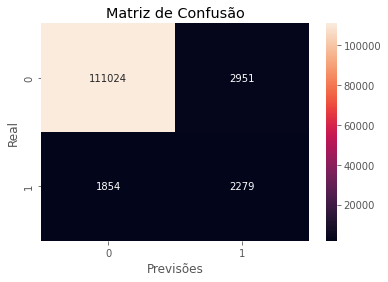

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.55      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 31s, sys: 400 ms, total: 1min 31s
Wall time: 1min 31s


In [187]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [188]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.26 s, sys: 56 ms, total: 1.32 s
Wall time: 1.32 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.486809783189149  0.978818882712594
Threshold: 0.05  0.486757795813755  0.978814381182445
Threshold: 0.1   0.486757795813755  0.978814381182445
Threshold: 0.15  0.486757795813755  0.978814381182445
Threshold: 0.2   0.486757795813755  0.978814381182445
Threshold: 0.25  0.486757795813755  0.978814381182445
Threshold: 0.3   0.486757795813755  0.978814381182445
Threshold: 0.35  0.486757795813755  0.978814381182445
Threshold: 0.4   0.486757795813755  0.978814381182445
Threshold: 0.45  0.486757795813755  0.978814381182445
Threshold: 0.5   0.486757795813755  0.978814381182445
Threshold: 0.55  0.486809783189149  0.978818882712594
Threshold: 0.6   0.486809783189149  0.978818882712594
Threshold: 0.65  0.486809783189149  0.978818882712594
Threshold: 0.7   0.486809783189149  0.978818882712594
Threshold: 0.75  0.486809783189149  0.978818882712594

0:	learn: 0.6045560	total: 84.2ms	remaining: 337ms
1:	learn: 0.5372958	total: 160ms	remaining: 240ms
2:	learn: 0.4914232	total: 244ms	remaining: 163ms
3:	learn: 0.4561740	total: 319ms	remaining: 79.7ms
4:	learn: 0.4150805	total: 402ms	remaining: 0us
0:	learn: 0.5383385	total: 7.29ms	remaining: 29.2ms
1:	learn: 0.4309601	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.3539234	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.2917101	total: 32.9ms	remaining: 8.23ms
4:	learn: 0.2531801	total: 40.5ms	remaining: 0us
0:	learn: 0.5387421	total: 7.6ms	remaining: 30.4ms
1:	learn: 0.4309962	total: 16.9ms	remaining: 25.3ms
2:	learn: 0.3540277	total: 24.8ms	remaining: 16.5ms
3:	learn: 0.2953996	total: 32.9ms	remaining: 8.23ms
4:	learn: 0.2451221	total: 41.4ms	remaining: 0us
0:	learn: 0.5385422	total: 7.33ms	remaining: 29.3ms
1:	learn: 0.4308737	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.3534565	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.2949700	total: 31.6ms	remaining: 7.9ms
4:	learn: 0.2448694	total: 39.

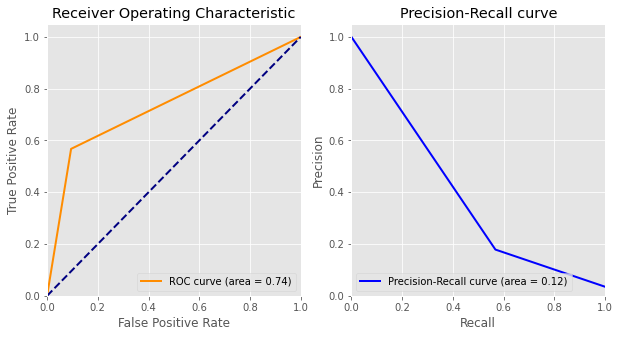

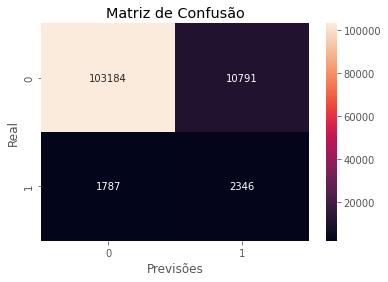

              precision    recall  f1-score   support

           0       0.98      0.91      0.94    113975
           1       0.18      0.57      0.27      4133

    accuracy                           0.89    118108
   macro avg       0.58      0.74      0.61    118108
weighted avg       0.95      0.89      0.92    118108

CPU times: user 54.1 s, sys: 776 ms, total: 54.9 s
Wall time: 37.1 s


In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [190]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 16.2 s, sys: 40 ms, total: 16.3 s
Wall time: 15.9 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.271685002895194  0.942552044796434
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067684195011709  0.002015952318345
Threshold: 0.25  0.072996085355305  0.162130358740419
Threshold: 0.3   0.088597505528924  0.448242818015618
Threshold: 0.35  0.122230503421641  0.707529066486059
Threshold: 0.4   0.170481411238991  0.838518143886711
Threshold: 0.45  0.230747325169847   0.91065277482458
Threshold: 0.5   0.271685002895194  0.942552044796434
Threshold: 0.55  0.306836616454229  0.959811171177627
Threshold: 0.6   0.365982273084259  0.975138911496989
Threshold: 0.65   0.33348844423763  0.981298608602553
Threshold: 0.7   0.315160042208934  0.983108489133735
Threshold: 0.75  0.179053330477618  0.983446125408664

F1-Score Positivo (Teste): 0.3487208008898776
F1-Score Negativo (Teste): 0.968832620615008
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.381651376146789
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9853967153442821
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score Nega

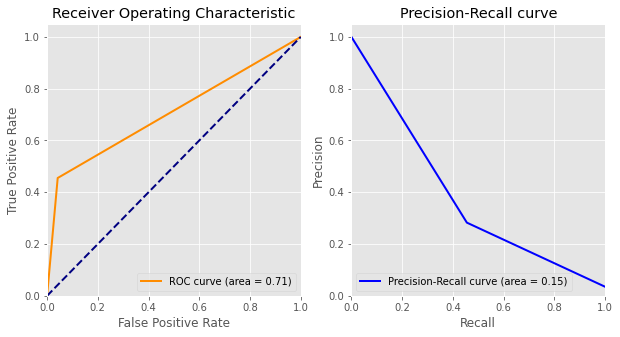

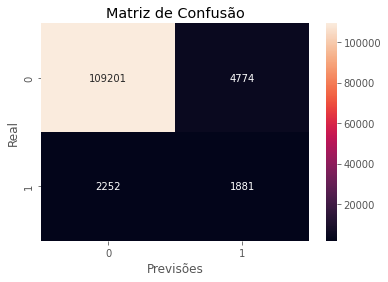

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.28      0.46      0.35      4133

    accuracy                           0.94    118108
   macro avg       0.63      0.71      0.66    118108
weighted avg       0.96      0.94      0.95    118108

CPU times: user 7min 43s, sys: 396 ms, total: 7min 44s
Wall time: 7min 43s


In [191]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [192]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.82 s, sys: 84 ms, total: 2.9 s
Wall time: 2.9 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.348720800889878  0.968832620615008
Threshold: 0.05  0.099561345208029  0.579218068651932
Threshold: 0.1   0.132314036725801  0.758635989783992
Threshold: 0.15   0.16054428807947  0.835746102449889
Threshold: 0.2    0.19151955122917  0.881011699229279
Threshold: 0.25  0.222986810846236  0.910435217797755
Threshold: 0.3   0.248612762584225  0.929797437416679
Threshold: 0.35  0.278928209106642  0.944941879804428
Threshold: 0.4   0.303326810176125  0.955080483804099
Threshold: 0.45  0.327532932184095  0.963066836967104
Threshold: 0.5   0.348720800889878  0.968832620615008
Threshold: 0.55  0.366817750606093  0.973505815312554
Threshold: 0.6   0.378320935175345  0.976882242137108
Threshold: 0.65  0.380990099009901  0.979491867162932
Threshold: 0.7   0.377541998231653  0.981589155733775
Threshold: 0.75  0.358907672301691   0.98285694415467

F1-Score Positivo (Teste): 0.34297022887626916
F1-Score Negativo (Teste): 0.9660008726858241
F1-Score Positivo Médio (Validação Cruzada): 0.33763844778730545
F1-Score Positivo Fold 1: 0.40733944954128437
F1-Score Positivo Fold 2: 0.349146110056926
F1-Score Positivo Fold 3: 0.34980988593155893
F1-Score Positivo Fold 4: 0.30115830115830117
F1-Score Positivo Fold 5: 0.36432637571157495
F1-Score Positivo Fold 6: 0.3551401869158879
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.27519379844961245
F1-Score Positivo Fold 9: 0.30174081237911027
F1-Score Positivo Fold 10: 0.32637571157495254
F1-Score Negativo Médio (Validação Cruzada): 0.9849324947645911
F1-Score Negativo Fold 1: 0.9860033799887334
F1-Score Negativo Fold 2: 0.9851483004979432
F1-Score Negativo Fold 3: 0.9851922410807067
F1-Score Negativo Fold 4: 0.9843317174515235
F1-Score Negativo Fold 5: 0.9854946958216065
F1-Score Negativo Fold 6: 0.985056525317278
F1-Score Negativo Fold 7: 0.985282659509999
F1-Scor

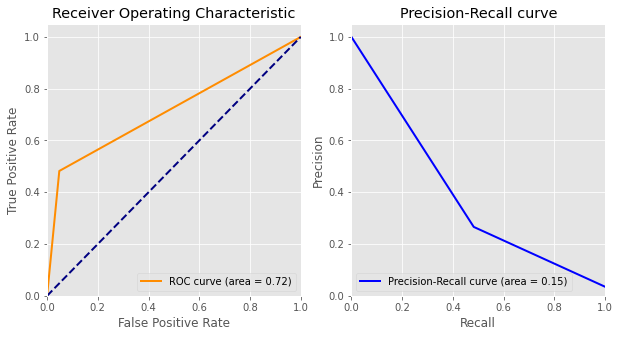

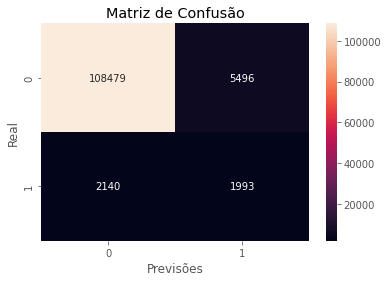

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.27      0.48      0.34      4133

    accuracy                           0.94    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.94      0.94    118108

CPU times: user 9min 19s, sys: 5.9 s, total: 9min 25s
Wall time: 9min 24s


In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [194]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 24.1 s, sys: 5.06 s, total: 29.2 s
Wall time: 29.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.342970228876269  0.966000872685824
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.342970228876269  0.966000872685824
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.31638706385150217
F1-Score Negativo (Teste): 0.9514054203564903
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score 

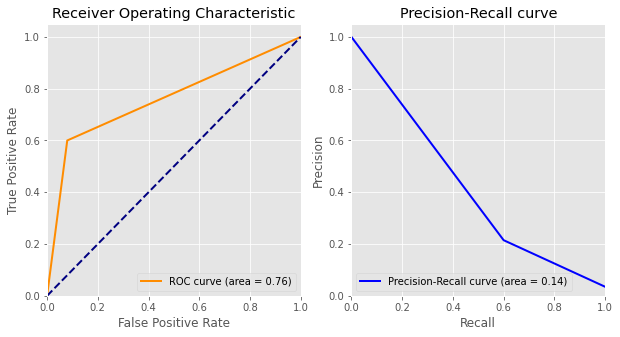

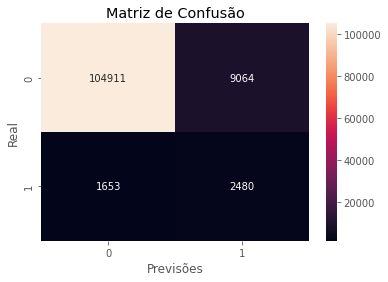

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.21      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 38min 9s, sys: 1.51 s, total: 38min 11s
Wall time: 3min 40s


In [195]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [196]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 32min 6s, sys: 3.4 s, total: 5h 32min 10s
Wall time: 30min 57s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.316387063851502   0.95140542035649
Threshold: 0.05  0.264703042008691  0.929338394290646
Threshold: 0.1   0.264703042008691  0.929338394290646
Threshold: 0.15  0.264703042008691  0.929338394290646
Threshold: 0.2   0.264703042008691  0.929338394290646
Threshold: 0.25  0.264703042008691  0.929338394290646
Threshold: 0.3   0.264703042008691  0.929338394290646
Threshold: 0.35  0.316387063851502   0.95140542035649
Threshold: 0.4   0.316387063851502   0.95140542035649
Threshold: 0.45  0.316387063851502   0.95140542035649
Threshold: 0.5   0.316387063851502   0.95140542035649
Threshold: 0.55  0.316387063851502   0.95140542035649
Threshold: 0.6   0.316387063851502   0.95140542035649
Threshold: 0.65  0.316387063851502   0.95140542035649
Threshold: 0.7   0.390873951164325  0.971361958077914
Threshold: 0.75  0.390873951164325  0.971361958077914

### Todas as colunas

In [197]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6752778612195856
F1-Score Negativo (Teste): 0.9905819008703683
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

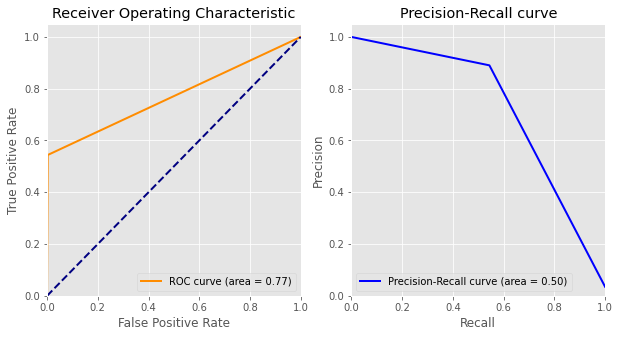

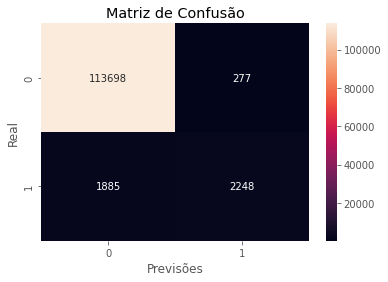

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 26s, sys: 300 ms, total: 8min 26s
Wall time: 8min 26s


In [198]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [199]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 55.5 s, sys: 4.01 ms, total: 55.5 s
Wall time: 55.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675277861219586  0.990581900870368
Threshold: 0.05  0.273720999405116  0.906678769348366
Threshold: 0.1   0.443788121990369   0.96073712501303
Threshold: 0.15   0.56411140812279  0.977495225248087
Threshold: 0.2   0.639122411318434   0.98445655341735
Threshold: 0.25  0.683488881207512  0.987927238207412
Threshold: 0.3   0.705487956295009  0.989603877946371
Threshold: 0.35  0.713930022277552  0.990449942034692
Threshold: 0.4   0.707029104887425  0.990678454737651
Threshold: 0.45  0.698571428571429  0.990794708920843
Threshold: 0.5   0.681263032469467  0.990675462523202
Threshold: 0.55  0.654714064914992  0.990276218084319
Threshold: 0.6   0.627720870678617  0.989885549293815
Threshold: 0.65  0.596153846153846  0.989417161922636
Threshold: 0.7   0.565336062777209  0.988938763815692
Threshold: 0.75  0.522924411400248  0.988311423577528

F1-Score Positivo (Teste): 0.4993472584856396
F1-Score Negativo (Teste): 0.9797290154344915
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

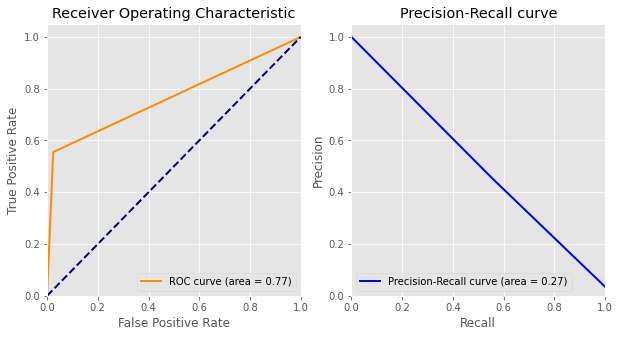

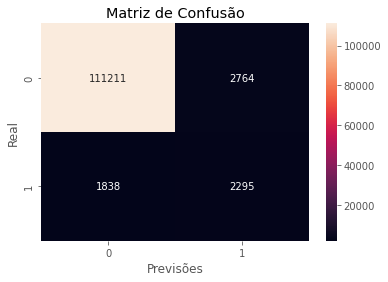

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.45      0.56      0.50      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.77      0.74    118108
weighted avg       0.97      0.96      0.96    118108

CPU times: user 1min 53s, sys: 368 ms, total: 1min 54s
Wall time: 1min 53s


In [200]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [201]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.49934725848564  0.979729015434492
Threshold: 0.05  0.499292940280648  0.979724521304009
Threshold: 0.1   0.499292940280648  0.979724521304009
Threshold: 0.15  0.499292940280648  0.979724521304009
Threshold: 0.2   0.499292940280648  0.979724521304009
Threshold: 0.25  0.499292940280648  0.979724521304009
Threshold: 0.3   0.499292940280648  0.979724521304009
Threshold: 0.35  0.499292940280648  0.979724521304009
Threshold: 0.4   0.499292940280648  0.979724521304009
Threshold: 0.45  0.499292940280648  0.979724521304009
Threshold: 0.5   0.499292940280648  0.979724521304009
Threshold: 0.55   0.49934725848564  0.979729015434492
Threshold: 0.6    0.49934725848564  0.979729015434492
Threshold: 0.65   0.49934725848564  0.979729015434492
Threshold: 0.7    0.49934725848564  0.979729015434492
Threshold: 0.75   0.49934725848564  0.979729015434492

0:	learn: 0.6025149	total: 88.8ms	remaining: 355ms
1:	learn: 0.5482334	total: 175ms	remaining: 263ms
2:	learn: 0.4968516	total: 265ms	remaining: 177ms
3:	learn: 0.4575837	total: 354ms	remaining: 88.6ms
4:	learn: 0.4239796	total: 444ms	remaining: 0us
0:	learn: 0.5336608	total: 8.47ms	remaining: 33.9ms
1:	learn: 0.4271318	total: 17.6ms	remaining: 26.3ms
2:	learn: 0.3416706	total: 27.1ms	remaining: 18.1ms
3:	learn: 0.2888256	total: 35.7ms	remaining: 8.92ms
4:	learn: 0.2438958	total: 44.8ms	remaining: 0us
0:	learn: 0.5331992	total: 8.86ms	remaining: 35.4ms
1:	learn: 0.4266171	total: 17.9ms	remaining: 26.9ms
2:	learn: 0.3413103	total: 27.4ms	remaining: 18.2ms
3:	learn: 0.2883925	total: 36ms	remaining: 9ms
4:	learn: 0.2434156	total: 45.5ms	remaining: 0us
0:	learn: 0.5334749	total: 8.53ms	remaining: 34.1ms
1:	learn: 0.4268605	total: 17.7ms	remaining: 26.6ms
2:	learn: 0.3408881	total: 26.7ms	remaining: 17.8ms
3:	learn: 0.2880311	total: 35.4ms	remaining: 8.86ms
4:	learn: 0.2431527	total: 44.4ms

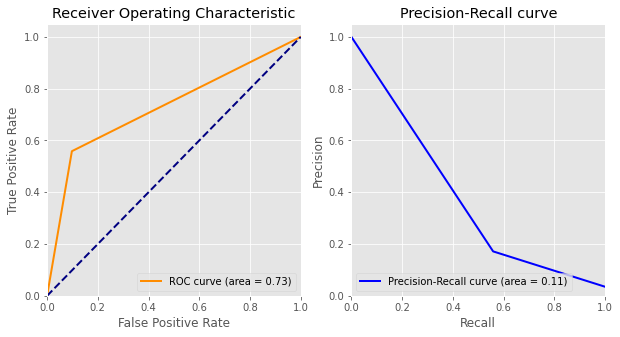

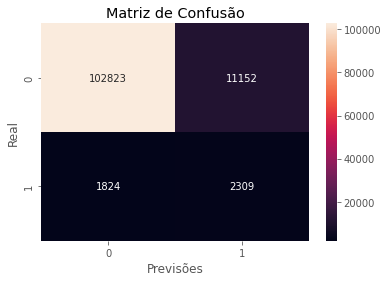

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    113975
           1       0.17      0.56      0.26      4133

    accuracy                           0.89    118108
   macro avg       0.58      0.73      0.60    118108
weighted avg       0.95      0.89      0.92    118108

CPU times: user 1min 46s, sys: 820 ms, total: 1min 47s
Wall time: 1min 24s


In [202]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [203]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 40.5 s, sys: 28.1 ms, total: 40.5 s
Wall time: 40.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.26247584403774  0.940646412529389
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.070031492041876  0.079712952512508
Threshold: 0.3   0.085700757575758  0.407040366255374
Threshold: 0.35  0.120854384473013  0.700839182265395
Threshold: 0.4   0.174770321818084  0.845620382933816
Threshold: 0.45  0.223176661264182  0.909367672642009
Threshold: 0.5    0.26247584403774  0.940646412529389
Threshold: 0.55  0.313802595359811  0.960962143346115
Threshold: 0.6   0.357247132429614  0.972801002532807
Threshold: 0.65  0.348618281202551   0.98131777206811
Threshold: 0.7   0.249951484572094  0.983272960188347
Threshold: 0.75  0.195830701200253  0.983500887815542

F1-Score Positivo (Teste): 0.3673193787981094
F1-Score Negativo (Teste): 0.9709584722535853
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

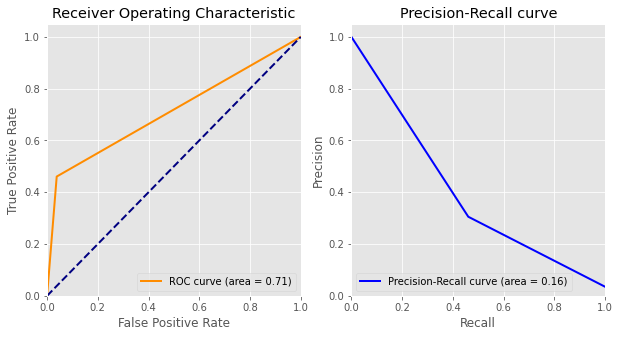

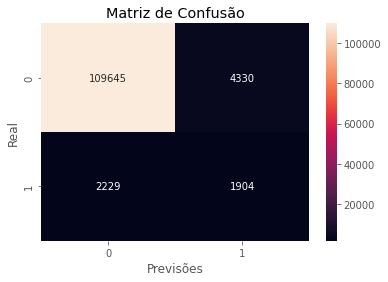

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.31      0.46      0.37      4133

    accuracy                           0.94    118108
   macro avg       0.64      0.71      0.67    118108
weighted avg       0.96      0.94      0.95    118108

CPU times: user 9min 4s, sys: 364 ms, total: 9min 5s
Wall time: 9min 4s


In [204]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [205]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.89 s, sys: 2 µs, total: 2.89 s
Wall time: 2.88 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.367319378798109  0.970958472253585
Threshold: 0.05  0.100378363413444  0.574471667404576
Threshold: 0.1   0.135615023291169  0.760157699192576
Threshold: 0.15  0.169397744200894  0.842798453359111
Threshold: 0.2   0.202463326875173  0.888805278999768
Threshold: 0.25  0.234704891844048  0.916805519701485
Threshold: 0.3   0.268355494823146  0.935903752031641
Threshold: 0.35  0.295133046675391  0.948625828340956
Threshold: 0.4   0.322136845956824  0.958378079631186
Threshold: 0.45  0.346248410343366  0.965640470365964
Threshold: 0.5   0.367319378798109  0.970958472253585
Threshold: 0.55  0.385004397537379  0.975369848538218
Threshold: 0.6   0.394843462246777  0.978388308903806
Threshold: 0.65  0.394967177242888  0.980673120609513
Threshold: 0.7   0.386569872958258  0.982334802529573
Threshold: 0.75  0.366881507188894  0.983355418938588

F1-Score Positivo (Teste): 0.3348318348318348
F1-Score Negativo (Teste): 0.964362812438672
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Nega

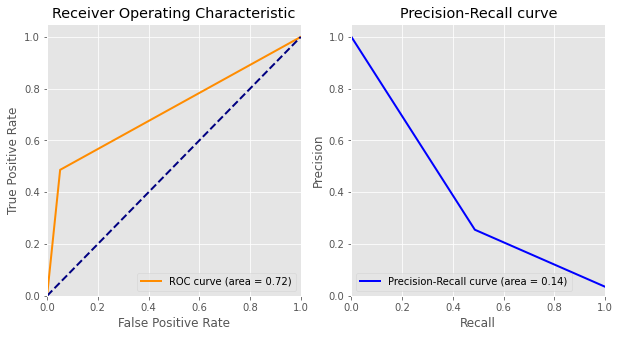

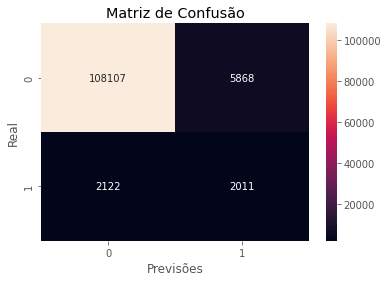

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.26      0.49      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 11min 20s, sys: 8.97 s, total: 11min 29s
Wall time: 11min 29s


In [206]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [207]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 35.3 s, sys: 144 ms, total: 35.4 s
Wall time: 35.4 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334831834831835  0.964362812438672
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.334831834831835  0.964362812438672
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

F1-Score Positivo (Teste): 0.3163402028967014
F1-Score Negativo (Teste): 0.9514153702452584
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

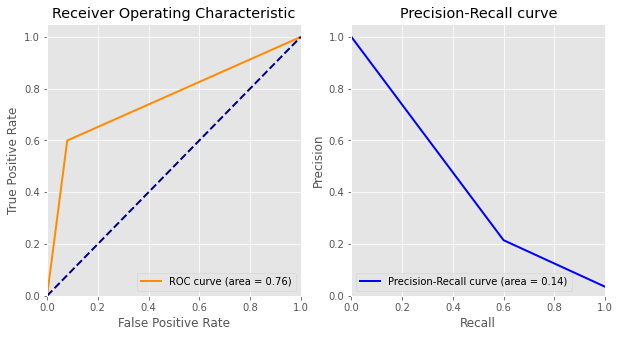

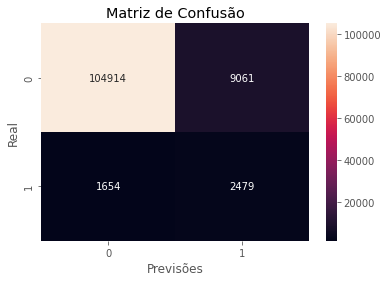

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.21      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 49min 8s, sys: 1.51 s, total: 49min 10s
Wall time: 4min 45s


In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [209]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 2min 2s, sys: 5.86 s, total: 8h 2min 7s
Wall time: 43min 31s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.316340202896701  0.951415370245258
Threshold: 0.05  0.264626375748214  0.929308584686775
Threshold: 0.1   0.264626375748214  0.929308584686775
Threshold: 0.15  0.264626375748214  0.929308584686775
Threshold: 0.2   0.264626375748214  0.929308584686775
Threshold: 0.25  0.264626375748214  0.929308584686775
Threshold: 0.3   0.264626375748214  0.929308584686775
Threshold: 0.35  0.316340202896701  0.951415370245258
Threshold: 0.4   0.316340202896701  0.951415370245258
Threshold: 0.45  0.316340202896701  0.951415370245258
Threshold: 0.5   0.316340202896701  0.951415370245258
Threshold: 0.55  0.316340202896701  0.951415370245258
Threshold: 0.6   0.316340202896701  0.951415370245258
Threshold: 0.65  0.316340202896701  0.951415370245258
Threshold: 0.7   0.390726604467062  0.971343720218967
Threshold: 0.75  0.390726604467062  0.971343720218967

# Cálculo tempo total do script

In [210]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.5e+04 s
